# Capstone 1: Forecasting Pharmacy Medication Sales

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



### Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](CRISP-DM-BANK.pdf) for more information on the data and features.



### Problem 1: Understanding the Data

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import math
from matplotlib import pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import statsmodels.api as sm
from statsmodels.tsa.filters.filtertools import convolution_filter
import statsmodels.graphics.tsaplots as tsplots
from statsmodels.tsa.seasonal import seasonal_decompose, STL
from statsmodels.tsa.forecasting.stl import STLForecast
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import _extrapolate_trend
from datetime import timedelta
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import tensorflow
from tensorflow.keras import Input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, SimpleRNN, Flatten, MaxPooling1D, Conv1D, GlobalAveragePooling1D
from keras import metrics
from array import array

2024-03-16 18:08:13.880230: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Problem 2: Read in the Data

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [2]:
sales_daily = pd.read_csv('salesdaily.csv')
sales_daily

,datum,M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06,Year,Month,Hour,Weekday Name
0,1/2/2014,0.00,3.670,3.40,32.40,7.0,0.0,0.0,2.00,2014,1,248,Thursday
1,1/3/2014,8.00,4.000,4.40,50.60,16.0,0.0,20.0,4.00,2014,1,276,Friday
2,1/4/2014,2.00,1.000,6.50,61.85,10.0,0.0,9.0,1.00,2014,1,276,Saturday
3,1/5/2014,4.00,3.000,7.00,41.10,8.0,0.0,3.0,0.00,2014,1,276,Sunday
4,1/6/2014,5.00,1.000,4.50,21.70,16.0,2.0,6.0,2.00,2014,1,276,Monday
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2101,10/4/2019,7.34,5.683,2.25,22.45,13.0,0.0,1.0,1.00,2019,10,276,Friday
2102,10/5/2019,3.84,5.010,6.00,25.40,7.0,0.0,0.0,0.33,2019,10,276,Saturday
2103,10/6/2019,4.00,11.690,2.00,34.60,6.0,0.0,5.0,4.20,2019,10,276,Sunday
2104,10/7/2019,7.34,4.507,3.00,50.80,6.0,0.0,10.0,1.00,2019,10,276,Monday


In [3]:
sales_daily.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2106 entries, 0 to 2105
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   datum         2106 non-null   object 
 1   M01AB         2106 non-null   float64
 2   M01AE         2106 non-null   float64
 3   N02BA         2106 non-null   float64
 4   N02BE         2106 non-null   float64
 5   N05B          2106 non-null   float64
 6   N05C          2106 non-null   float64
 7   R03           2106 non-null   float64
 8   R06           2106 non-null   float64
 9   Year          2106 non-null   int64  
 10  Month         2106 non-null   int64  
 11  Hour          2106 non-null   int64  
 12  Weekday Name  2106 non-null   object 
dtypes: float64(8), int64(3), object(2)
memory usage: 214.0+ KB


In [4]:
sales_weekly = pd.read_csv('salesweekly.csv')
sales_weekly

,datum,M01AB,M01AE,N02BA,N02BE,N05B,N05C,R03,R06
0,1/5/2014,14.00,11.670,21.30,185.950,41.0,0.0,32.000000,7.00
1,1/12/2014,29.33,12.680,37.90,190.700,88.0,5.0,21.000000,7.20
2,1/19/2014,30.67,26.340,45.90,218.400,80.0,8.0,29.000000,12.00
3,1/26/2014,34.00,32.370,31.50,179.600,80.0,8.0,23.000000,10.00
4,2/2/2014,31.02,23.350,20.70,159.880,84.0,12.0,29.000000,12.00
...,...,...,...,...,...,...,...,...,...
297,9/15/2019,35.51,30.977,19.65,178.375,67.2,5.0,30.000000,30.50
298,9/22/2019,46.84,25.396,24.40,248.250,31.2,3.0,26.000000,21.00
299,9/29/2019,34.01,22.498,26.60,336.700,61.2,1.0,40.416667,23.10
300,10/6/2019,38.70,32.502,19.25,249.450,69.0,5.0,30.000000,12.13


### Problem 3: Understanding the Features


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Initial dataset consisted of 600000 transactional data collected in 6 years (period 2014-2019), indicating date and time of sale, pharmaceutical drug brand name and sold quantity. As a result of the interviews with pharmacists, decision was made that the subject of analyses and forecasting will be actual drug categories, instead of the individual drugs. Thus, selected group of drugs (57 drugs) is classified to 8 Anatomical Therapeutic Chemical (ATC) Classification System categories:

Input variables:
# Medication categories:
M01AB - Anti-inflammatory and antirheumatic products, non-steroids, Acetic acid derivatives and related substances
M01AE - Anti-inflammatory and antirheumatic products, non-steroids, Propionic acid derivatives
N02BA - Other analgesics and antipyretics, Salicylic acid and derivatives
N02BE/B - Other analgesics and antipyretics, Pyrazolones and Anilides
N05B - Psycholeptics drugs, Anxiolytic drugs
N05C - Psycholeptics drugs, Hypnotics and sedatives drugs
R03 - Drugs for obstructive airway diseases
R06 - Antihistamines for systemic use

Output:
Short term and long term forecast of sales for 4 of the medication categories:
M01AB - Anti-inflammatory and antirheumatic products, non-steroids, Acetic acid derivatives and related substances
N02BE - Other analgesics and antipyretics, Pyrazolones and Anilides
R03 - Drugs for obstructive airway diseases
R06 - Antihistamines for systemic use
```



In [5]:
med_name = 'R06'
med_description = 'Antihistamines for systemic use'

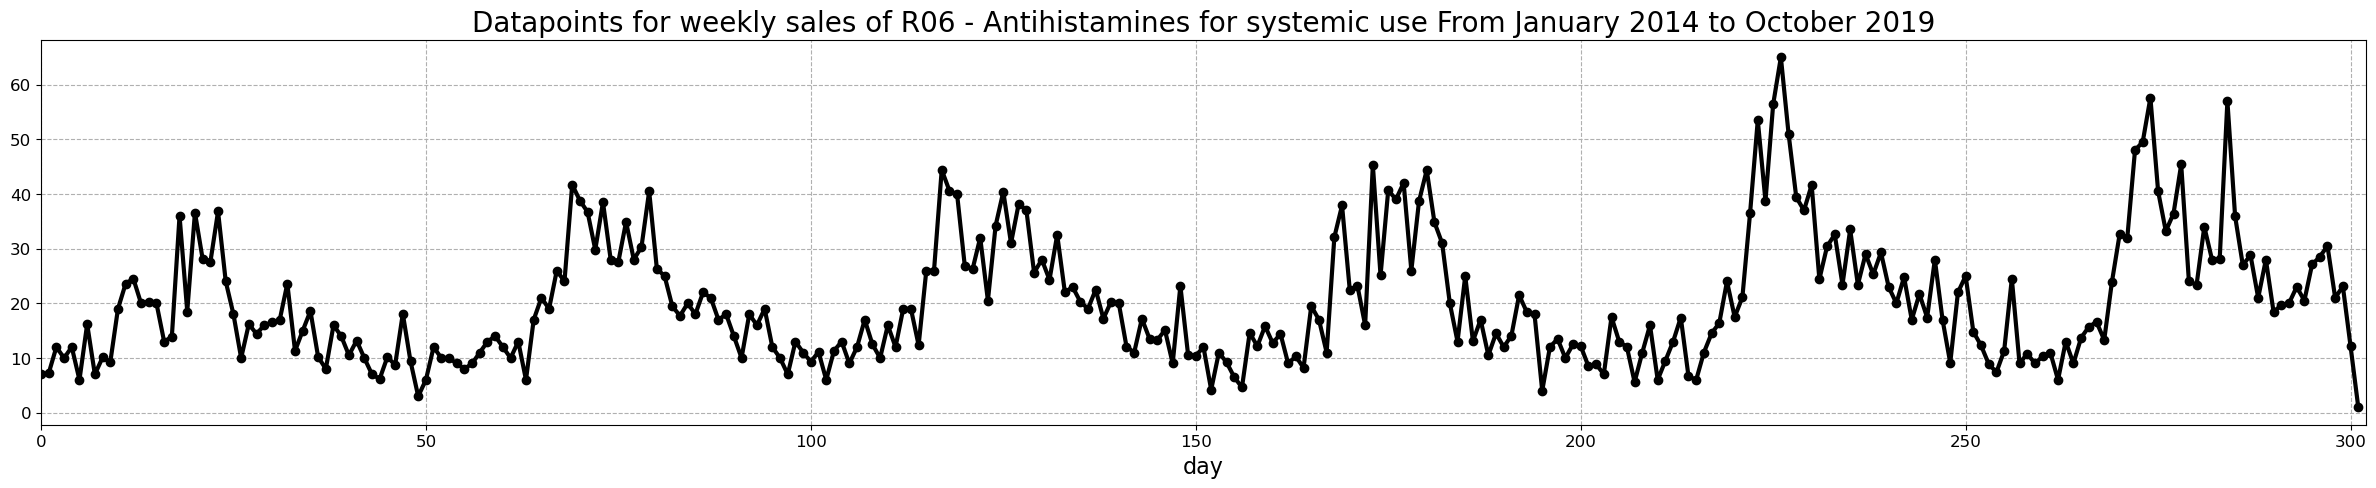

In [6]:
plt.figure(figsize=(30,5))
plt.plot(sales_weekly['R06'],'ko-',linewidth=3)
plt.grid(linestyle='--')
plt.xlim(0,302)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('day',fontsize=16)
plt.title("Datapoints for weekly sales of " + med_name + " - " + med_description +  " From January 2014 to October 2019", fontsize=20)
plt.savefig(med_name + "-focus.png")

### Problem 4: Understanding the Task

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

Business Objective: 
To generate short-term and long-term predictions on the sales of four drug categories:
```
M01AB - Anti-inflammatory and antirheumatic products, non-steroids, Acetic acid derivatives and related substances
N02BE - Other analgesics and antipyretics, Pyrazolones and Anilides
R03 - Drugs for obstructive airway diseases
R06 - Antihistamines for systemic use
```

### Problem 5: Engineering Features

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Prepare the features and target column for modeling with appropriate encoding and transformations.

In [7]:
#### R06 - Antihistamines for systemic use

In [8]:
df_r06_weekly = sales_weekly[['datum','R06']].set_index(pd.to_datetime(sales_weekly['datum'])) \
    .drop(columns=['datum'])
df_r06_weekly.rename(columns={"R06": "values"}, inplace=True)
df_r06_weekly

,values
datum,
2014-01-05,7.00
2014-01-12,7.20
2014-01-19,12.00
2014-01-26,10.00
2014-02-02,12.00
...,...
2019-09-15,30.50
2019-09-22,21.00
2019-09-29,23.10


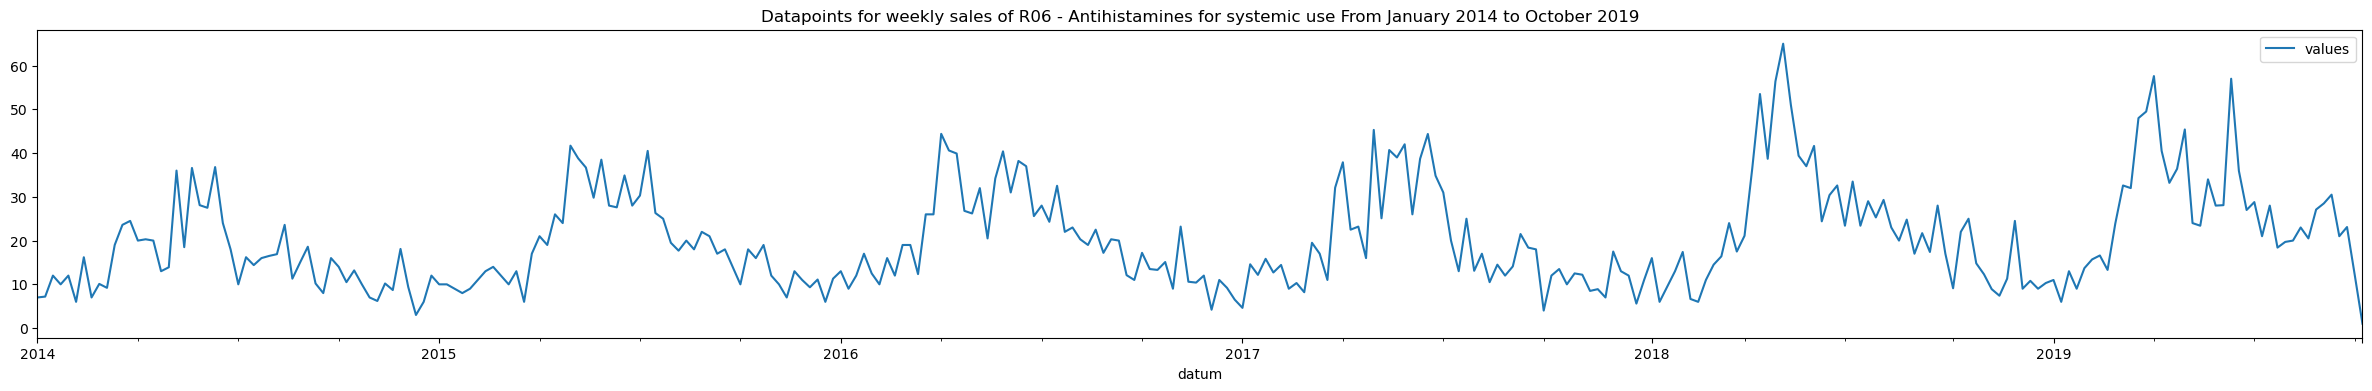

In [9]:
df_r06_weekly.plot(figsize=(30,4))
plt.title("Datapoints for weekly sales of " + med_name + " - " + med_description +  " From January 2014 to October 2019")
plt.savefig(med_name + "-dataframe.png")

In [10]:
df_r06_weekly.index.year.value_counts()

datum
2017    53
2014    52
2015    52
2016    52
2018    52
2019    41
Name: count, dtype: int64

In [11]:
# period is about 52 weeks
period_r06 = 52

### Problem 6: Train/Test Split

With your data prepared, split it into a train and test set.

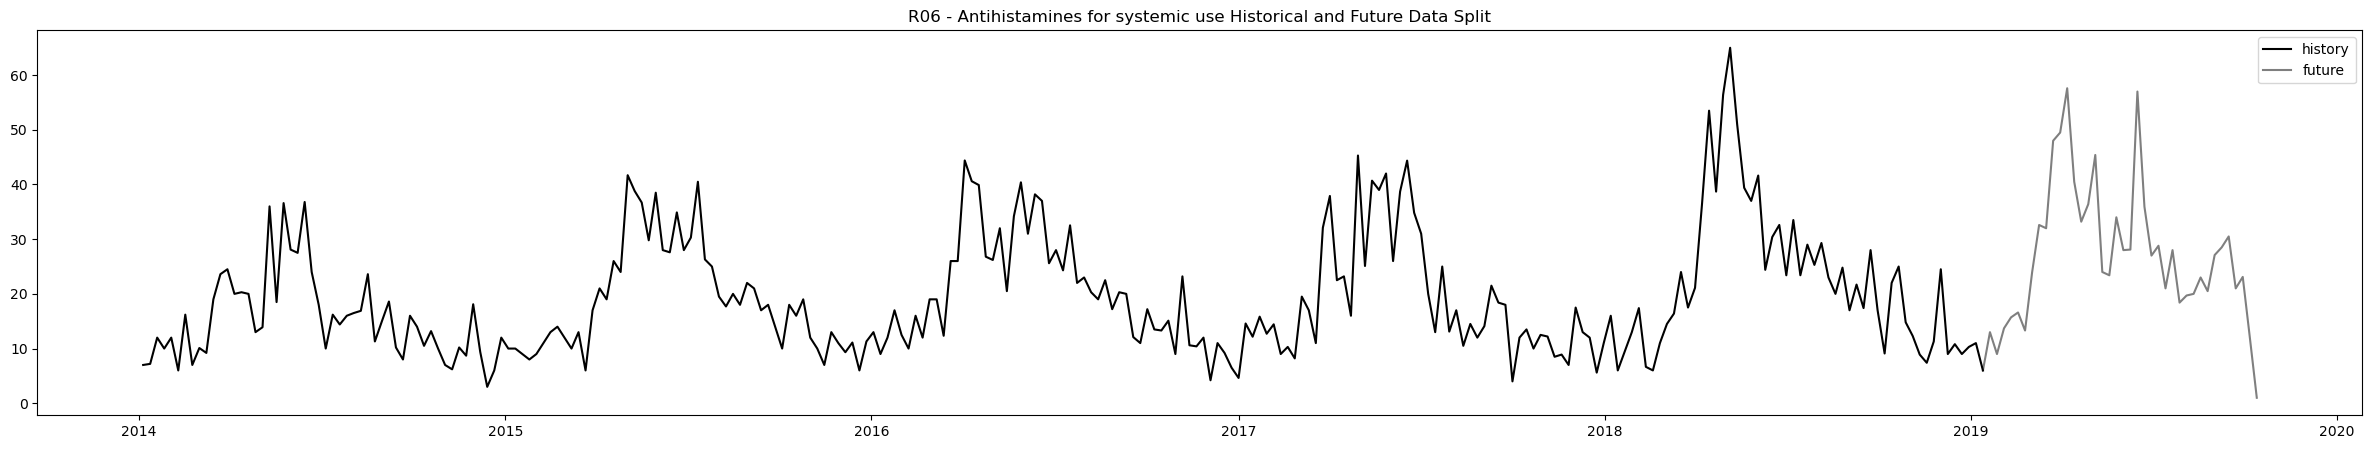

In [12]:
y_r06_hist = df_r06_weekly.loc[:'2019-01-14','values']
y_r06_future = df_r06_weekly.loc['2019-01-13':,'values']

plt.figure(figsize=(30,5))
plt.plot(y_r06_hist,'k', label='history')
plt.plot(y_r06_future,'k',alpha=0.5, label='future')
plt.legend()
plt.title(med_name + " - " + med_description + " Historical and Future Data Split")
plt.savefig(med_name + "-train-test-split.png")

### Problem 7: A Baseline Model

Before we build our first model, we want to establish a baseline.  We will use decomposition as our baseline.

In [13]:
def decompose(df, column_name, modelname, pltname):
    result = seasonal_decompose(df[column_name], model=modelname, extrapolate_trend = 'freq', period=period_r06)
    return result

In [14]:
def decom_plot(res, plotname):
    plt.figure(figsize=(30,5))
    plt.title(plotname + ' Seasonal Decomposition Model')
    plt.plot(res.seasonal,'k',label='seasonal')
    plt.plot(res.trend,'r',linewidth=1,label='trend')
    plt.plot(res.resid,'g',alpha=0.5,label='residual')
    plt.plot(res.observed, 'b',alpha=0.5,label='actual_value')
    plt.legend()
    plt.savefig(plotname + "-seasonal-decomp-model.png")

In [15]:
def reconstruct(decom_res):
    df_recon = pd.concat([decom_res.seasonal, decom_res.trend, decom_res.resid, decom_res.observed], axis = 1)
    df_recon.columns = ['seasonal', 'trend', 'residual', 'actual_values']
    
    return df_recon

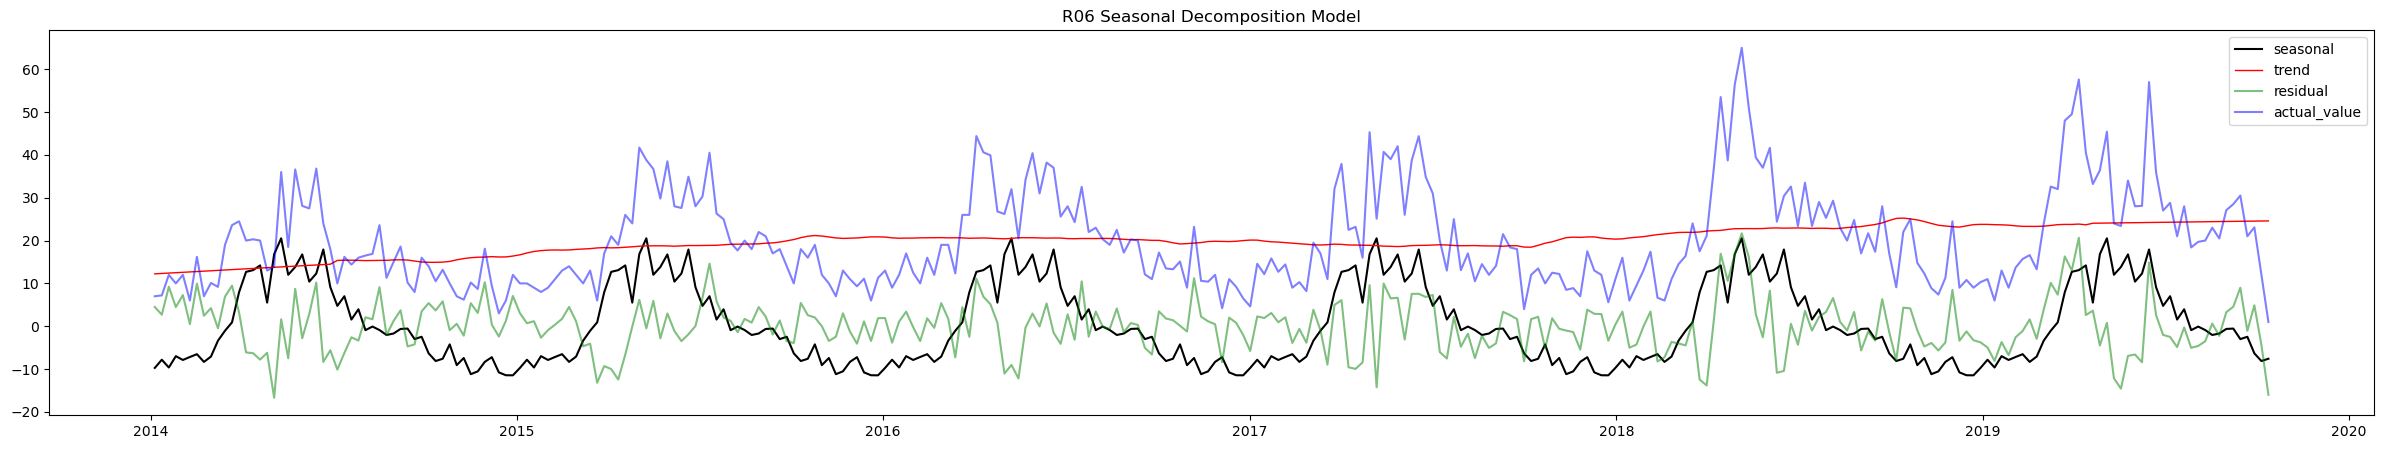

In [16]:
r06_residual = decompose(df_r06_weekly, "values", 'additive', med_name)
r06_recon_df = reconstruct(r06_residual)
decom_plot(r06_residual, med_name)

In [17]:
r06_recon_df

,seasonal,trend,residual,actual_values
datum,,,,
2014-01-05,-9.727442,12.229754,4.497688,7.00
2014-01-12,-7.813518,12.319927,2.693591,7.20
2014-01-19,-9.628760,12.410100,9.218661,12.00
2014-01-26,-6.979152,12.500272,4.478880,10.00
2014-02-02,-7.870623,12.590445,7.280178,12.00
...,...,...,...,...
2019-09-15,-2.999367,24.500534,8.998833,30.50
2019-09-22,-2.454101,24.522209,-1.068108,21.00
2019-09-29,-6.325983,24.543884,4.882099,23.10


##### Residual Size

In [18]:
MAEm = np.abs(r06_recon_df['residual']).mean()
RMSEm = np.sqrt( np.square(r06_recon_df['residual']).mean() )
MAEm, RMSEm

(4.681426284791636, 6.102016745560865)

##### Residual Stationarity

In [19]:
def plot_acf_colors(ax, markercolor="purple", linecolor="purple", facecolor="silver", barcolor="black", linewidth=1):
    """utility function to get some control over colors with  plot_acf()"""
    from statsmodels.graphics.tsaplots import plot_pacf
    from statsmodels.graphics.tsaplots import plot_acf
    from matplotlib.collections import PolyCollection, LineCollection
    for item in ax.collections:
        # change the color of the confidence interval 
        if type(item) == PolyCollection:
            item.set_facecolor(facecolor)
        # change the color of the vertical lines
        if type(item) == LineCollection:
            item.set_color(barcolor)
    # change the color of the markers
    [line.get_label() for line in ax.lines]
    for item in ax.lines:
        item.set_color(markercolor)
    # change the color of the horizontal lines
    ax.lines[0].set_color(linecolor)
    ax.lines[0].set_linewidth(linewidth)
    #ax.lines.remove(ax.lines[0])
    return ax

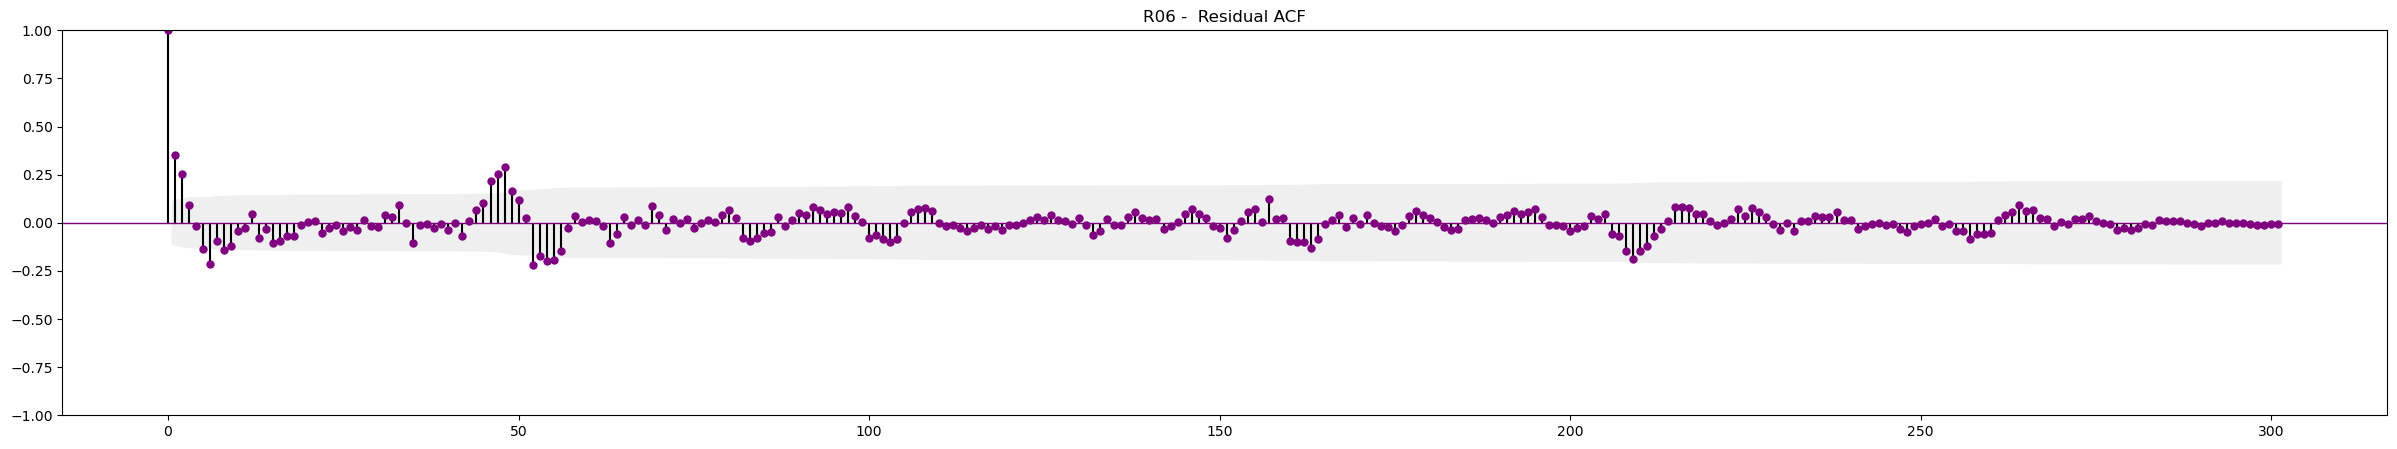

In [20]:
f, ax = plt.subplots(figsize=(30,5))
plot_acf(r06_recon_df['residual'], lags=301, ax=ax)
plt.title(med_name + " - " + " Residual ACF")
ax = plot_acf_colors(ax)
plt.savefig(med_name + "-acf.png")

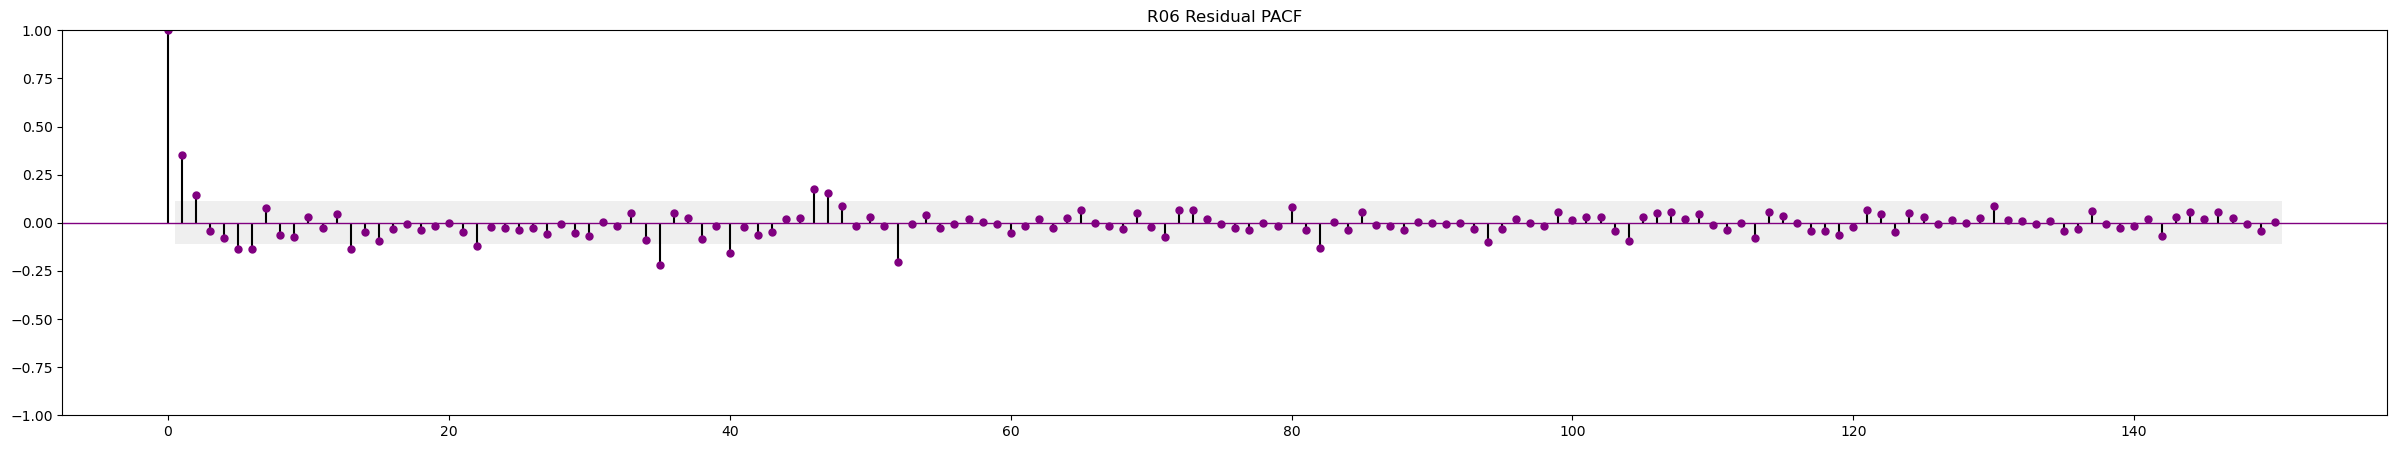

In [21]:
f, ax = plt.subplots(figsize=(30, 5))
plot_pacf(r06_recon_df['residual'], lags=150, ax=ax)
ax = plot_acf_colors(ax)
plt.title(med_name + " Residual PACF")
plt.savefig(med_name + "-pacf.png")

Residual ACF and PACF seem to be pretty stationary.

**AdFuller Stationarity test**
* The ADF statistic is a test statistic used to determine the stationarity of the time series. The larger the ADF statistic, the more likely the time series is stationary.
* The p-value indicates the probability of observing the given ADF statistic (or a more extreme value) if the null hypothesis (the time series is non-stationary) is true. If the p-value is less than a specified significance level (e.g., 0.05), we reject the null hypothesis and conclude that the time series is stationary.

In [22]:
stationary_test = adfuller(r06_recon_df['residual'])
print('ADF Statistic: %f' % stationary_test[0])
print('p-value: %f' % stationary_test[1])
stationary_test

ADF Statistic: -8.373727
p-value: 0.000000


(-8.373727310946922,
 2.6201042311827e-13,
 5,
 296,
 {'1%': -3.452636878592149,
  '5%': -2.8713543954331433,
  '10%': -2.5719993576515705},
 1796.3390777683212)

p-value is less than 0.05, therefore the residual model seems to be stationary.

### Problem 8: A Simple Model

Use Decomposition to build a basic model on your data.  

#### Extract the Trend

In [23]:
period = 52

filt = np.ones(period+1)
filt[0] = 0.5
filt[-1] = 0.5
filt /= period

In [24]:
trend = convolution_filter(y_r06_hist, filt)
trend = _extrapolate_trend(trend, period + 1)

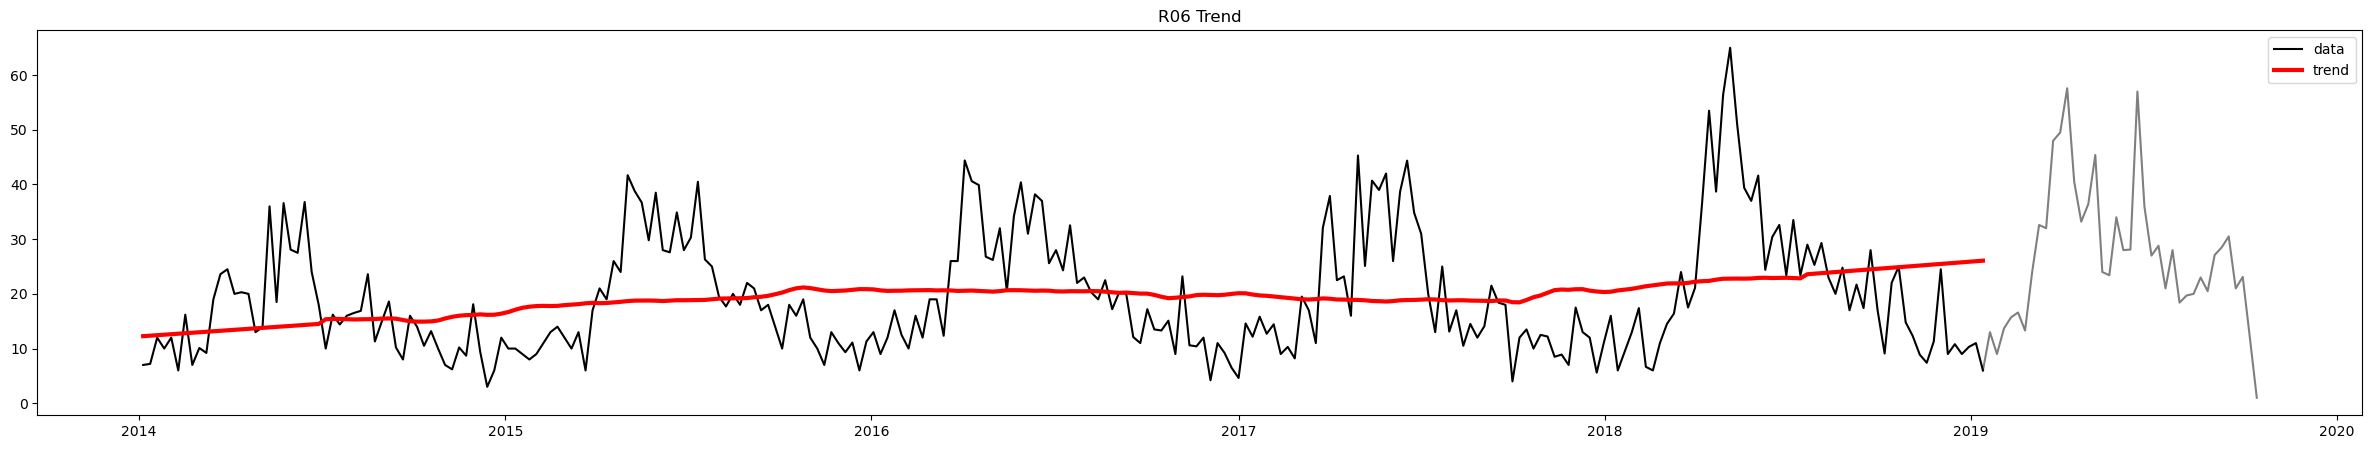

In [25]:
plt.figure(figsize=(30,5))
plt.plot(y_r06_hist,'k',label='data')
plt.plot(trend,'r',linewidth=3,label='trend')
plt.plot(y_r06_future,'k',alpha=0.5)
plt.legend()
plt.title(med_name + " Trend")
plt.savefig(med_name + "-trend.png")

#### Detrended data

In [26]:
detrended = y_r06_hist - trend
detrended = detrended.to_numpy()

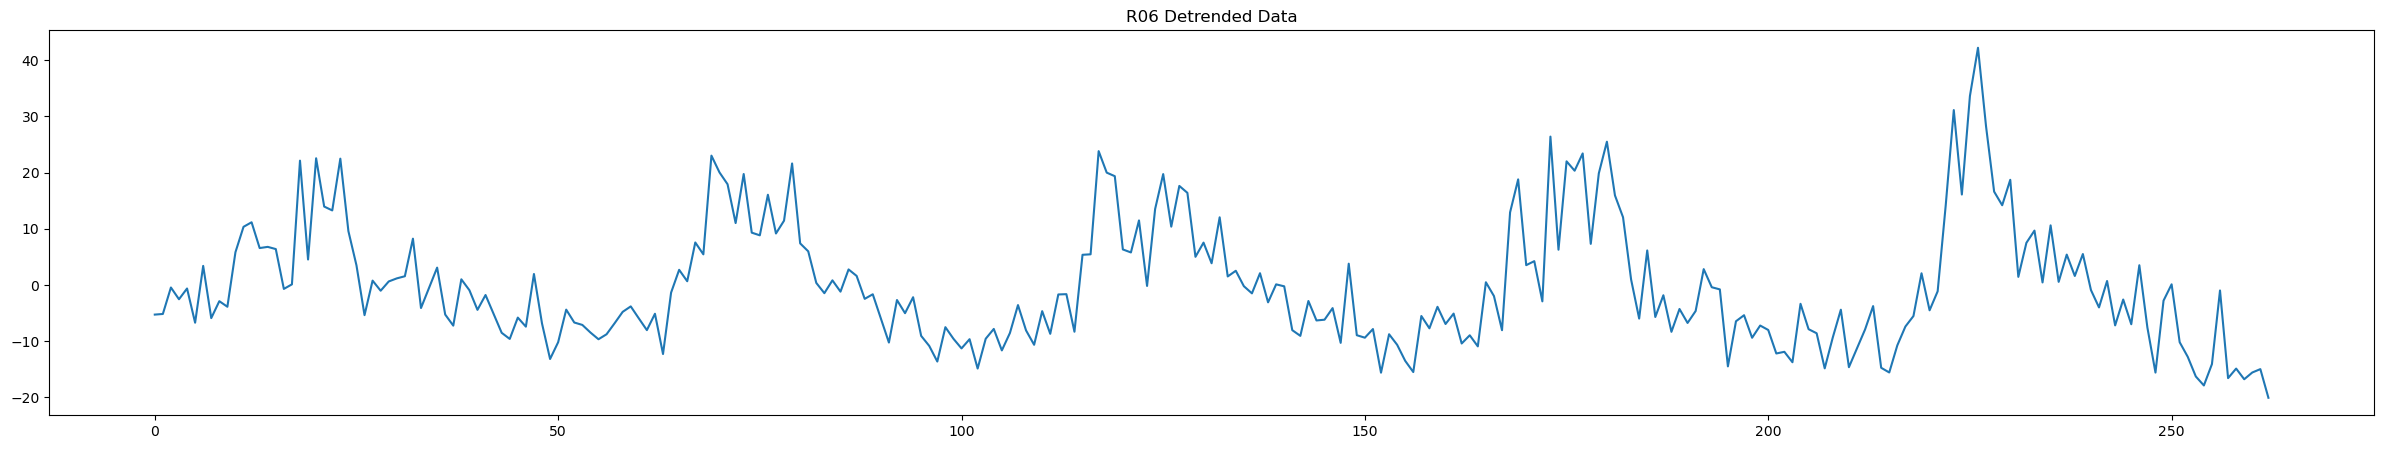

In [27]:
plt.figure(figsize=(30,5))
plt.plot(detrended)
plt.savefig("R06-detrended.png")
plt.title(med_name + " Detrended Data")
plt.savefig(med_name + "-detrended.png")

#### Split the historical data into seasons

In [28]:
sales_weekly[['datum','R06']].query('R06 < 10')

,datum,R06
0,1/5/2014,7.000
1,1/12/2014,7.200
5,2/9/2014,6.000
7,2/23/2014,7.000
9,3/9/2014,9.200
37,9/21/2014,8.000
43,11/2/2014,7.000
44,11/9/2014,6.200
46,11/23/2014,8.700
48,12/7/2014,9.400


In [29]:
lows_index = [0, 49, 102, 156, 207, 262]
lows = y_r06_hist.index[lows_index]
lows

DatetimeIndex(['2014-01-05', '2014-12-14', '2015-12-20', '2017-01-01',
               '2017-12-24', '2019-01-13'],
              dtype='datetime64[ns]', name='datum', freq=None)

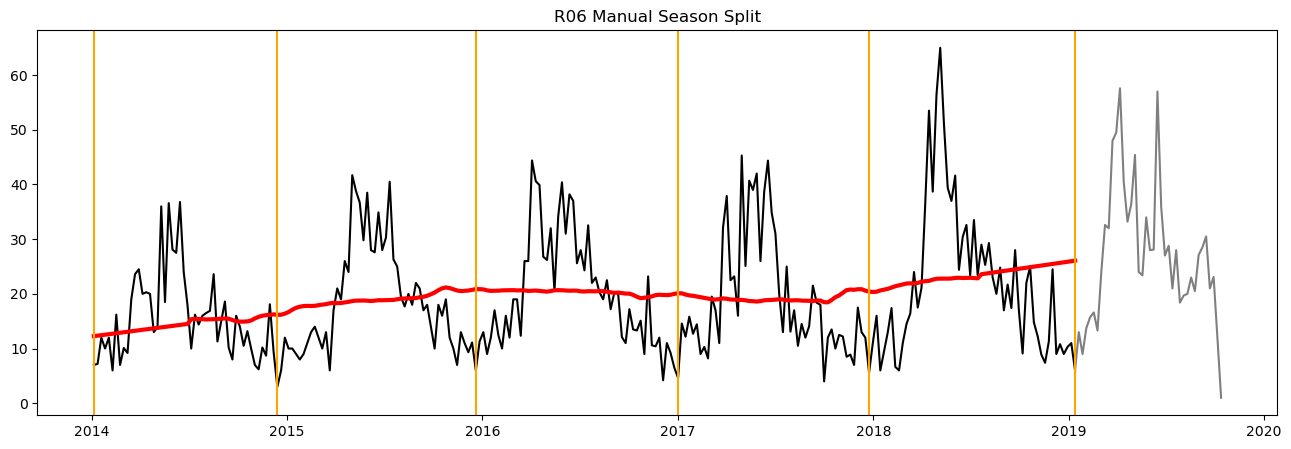

In [30]:
plt.figure(figsize=(16,5))
plt.plot(y_r06_hist,'k')
plt.plot(y_r06_future,'k',alpha=0.5)
plt.plot(trend,'r',linewidth=3)
for low in lows:
    plt.axvline(x=pd.to_datetime(low),color='orange')

plt.title(med_name + " Manual Season Split")
plt.savefig(med_name + "-season-manual-split.png")

#### Divide the detrended data into seasons

In [31]:
period = int(np.round(np.mean(np.diff(lows_index))))
num_seasons = len(lows)-1
print(period)
print(num_seasons)

52
5


In [32]:
seasonals = np.empty((period,num_seasons))
for p in range(num_seasons):
    s = detrended[lows_index[p]:lows_index[p]+period]
    s = 2*(s-np.min(s))/(np.max(s)-np.min(s))
    seasonals[:,p] = s
    
mean_seasonals = seasonals.mean(axis=1)

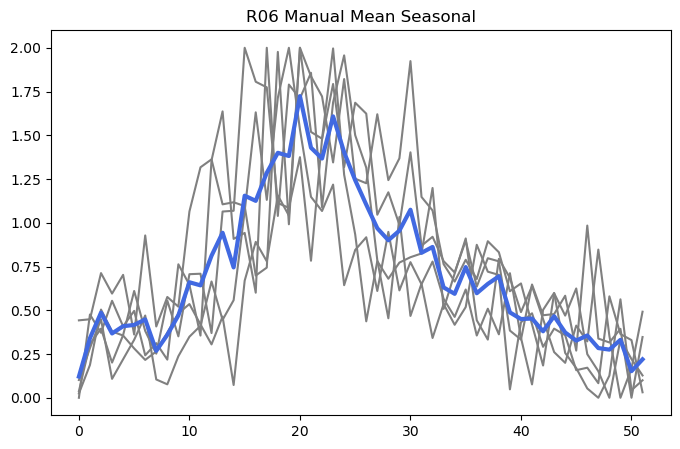

In [33]:
plt.figure(figsize=(8,5))
for p in range(num_seasons):
    plt.plot(seasonals[:,p],color=0.5*np.ones(3))
plt.plot(mean_seasonals,color='royalblue',linewidth=3)
plt.title(med_name + " Manual Mean Seasonal")
plt.savefig(med_name + "-season-manual-mean.png")

#### Smooth the seasonal data

In [34]:
filt_size = 2
filt = np.repeat(1.0 / filt_size, filt_size)

seasonals = np.empty((period,num_seasons))
for p in range(num_seasons):
    s = detrended[lows_index[p]:lows_index[p]+period]
    s = convolution_filter(s, filt)
    s = _extrapolate_trend(s, filt_size)
    s = (s-np.min(s))/(np.max(s)-np.min(s))
    seasonals[:,p] = s
    
mean_seasonals = seasonals.mean(axis=1)

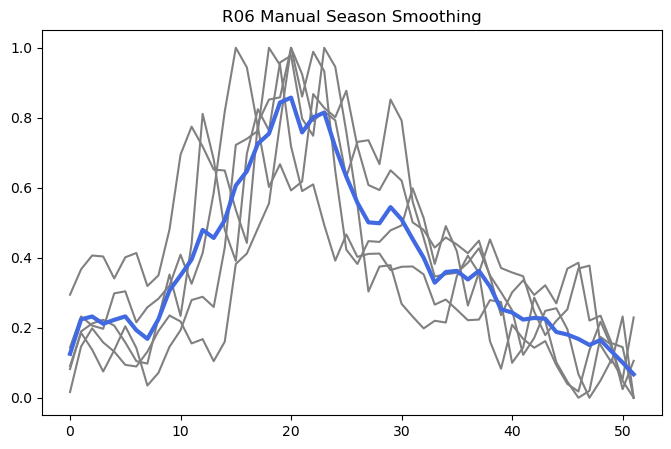

In [35]:
plt.figure(figsize=(8,5))
for p in range(num_seasons):
    plt.plot(seasonals[:,p],color=0.5*np.ones(3))
plt.plot(mean_seasonals,color='royalblue',linewidth=3)
plt.title(med_name + " Manual Season Smoothing")
plt.savefig(med_name + "-season-manual-smoothing.png")

#### Remove outliers

In [36]:
seasonals = seasonals[:,[0, 1, 2, 3, 4]]
mean_seasonals = seasonals.mean(axis=1)

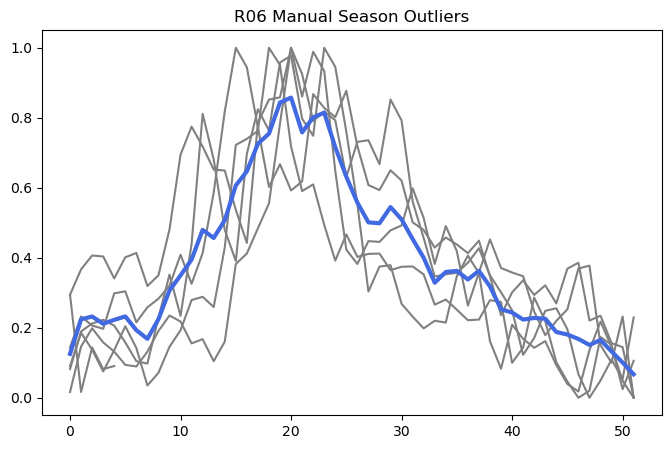

In [37]:
plt.figure(figsize=(8,5))
plt.plot(seasonals[0],color=0.5*np.ones(3),label='historical data')
plt.plot(seasonals,color=0.5*np.ones(3))
plt.plot(mean_seasonals,color='royalblue',linewidth=3)
plt.title(med_name + " Manual Season Outliers")
plt.savefig(med_name + "-season-manual-outliers.png")

#### Build the seasonal template

In [38]:
seasonal = pd.Series(index=y_r06_hist.index,data=0)

for low in lows_index:
    if low+period<len(seasonal):
        seasonal[low:low+period] = mean_seasonals
    else:
        seasonal[low:] = mean_seasonals[:len(seasonal)-(low+period)]
        
seasonal = seasonal / np.max(seasonal)

/tmp/ipykernel_1091798/4166925191.py:5: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.12550802 0.22421307 0.23219379 0.21140968 0.22267115 0.23243441
 0.19317471 0.16843137 0.22458404 0.30676456 0.3496789  0.39497816
 0.47970415 0.45667487 0.50729014 0.60646967 0.64720264 0.72591813
 0.75464459 0.84367759 0.85760188 0.7582229  0.80111823 0.81466822
 0.71598376 0.63159301 0.55755493 0.50118942 0.49866582 0.54478108
 0.50957956 0.45352702 0.4000345  0.32876815 0.35943003 0.36254039
 0.33800454 0.36268723 0.31782634 0.25292003 0.24355588 0.22346326
 0.22801483 0.22596113 0.18803294 0.18064149 0.16811358 0.15087093
 0.16505137 0.13236989 0.10070964 0.06700691]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  seasonal[low:low+period] = mean_seasonals


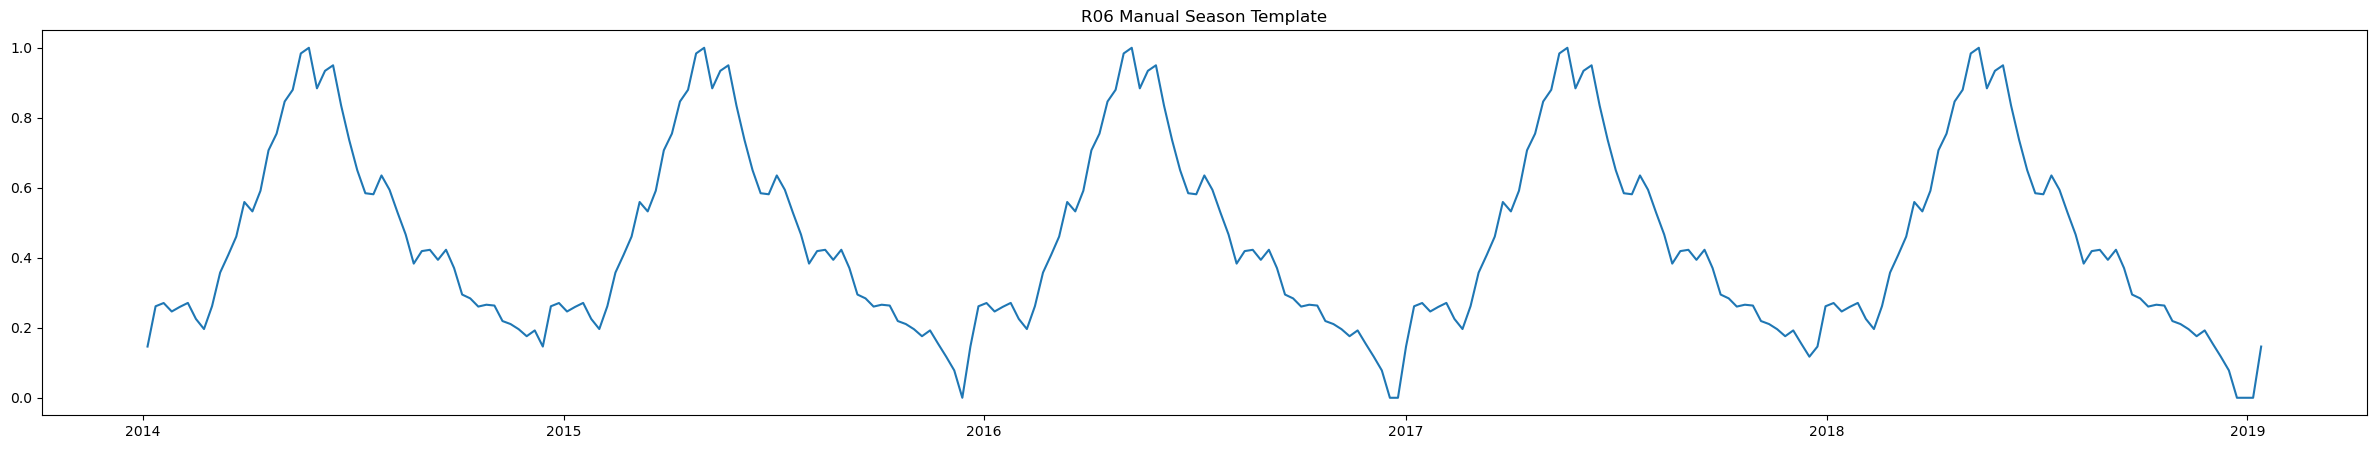

In [39]:
plt.figure(figsize=(30,5))
plt.plot(seasonal)
plt.title(med_name + " Manual Season Template")
plt.savefig(med_name + "-season-manual-template.png")

#### Final model

In [40]:
# season_and_trend = 2*trend*seasonal
season_and_trend = 2 * trend * seasonal

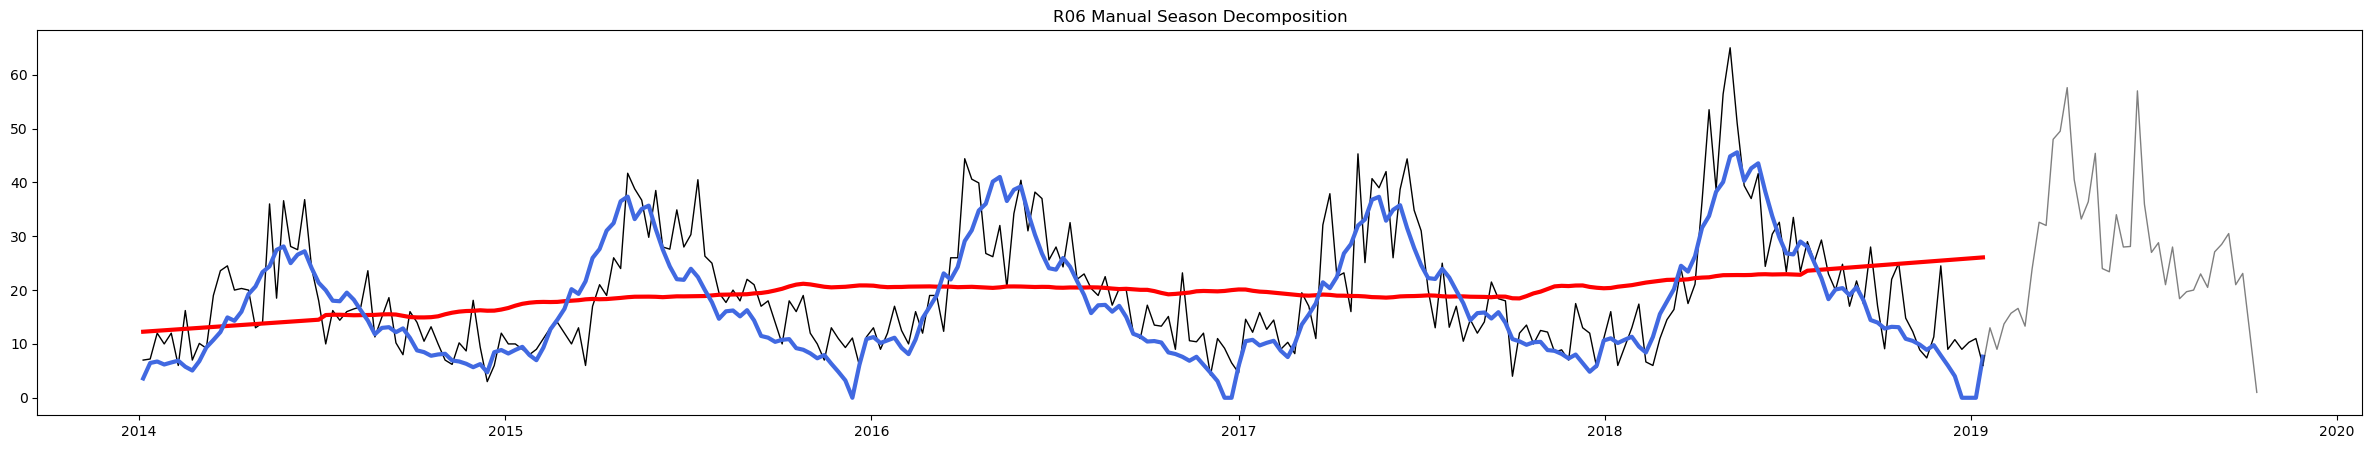

In [41]:
plt.figure(figsize=(30,5))
plt.plot(y_r06_hist,'k',label='data',linewidth=1)
plt.plot(trend,label='trend',color='red',linewidth=3)
plt.plot(season_and_trend,label='trend & seasonal',color='royalblue',linewidth=3)
plt.plot(y_r06_future,'k',alpha=0.5,linewidth=1)
plt.title(med_name + " Manual Season Decomposition")
plt.savefig(med_name + "-decomp-model-manual.png")

#### Model residue

In [42]:
residue = y_r06_hist - season_and_trend

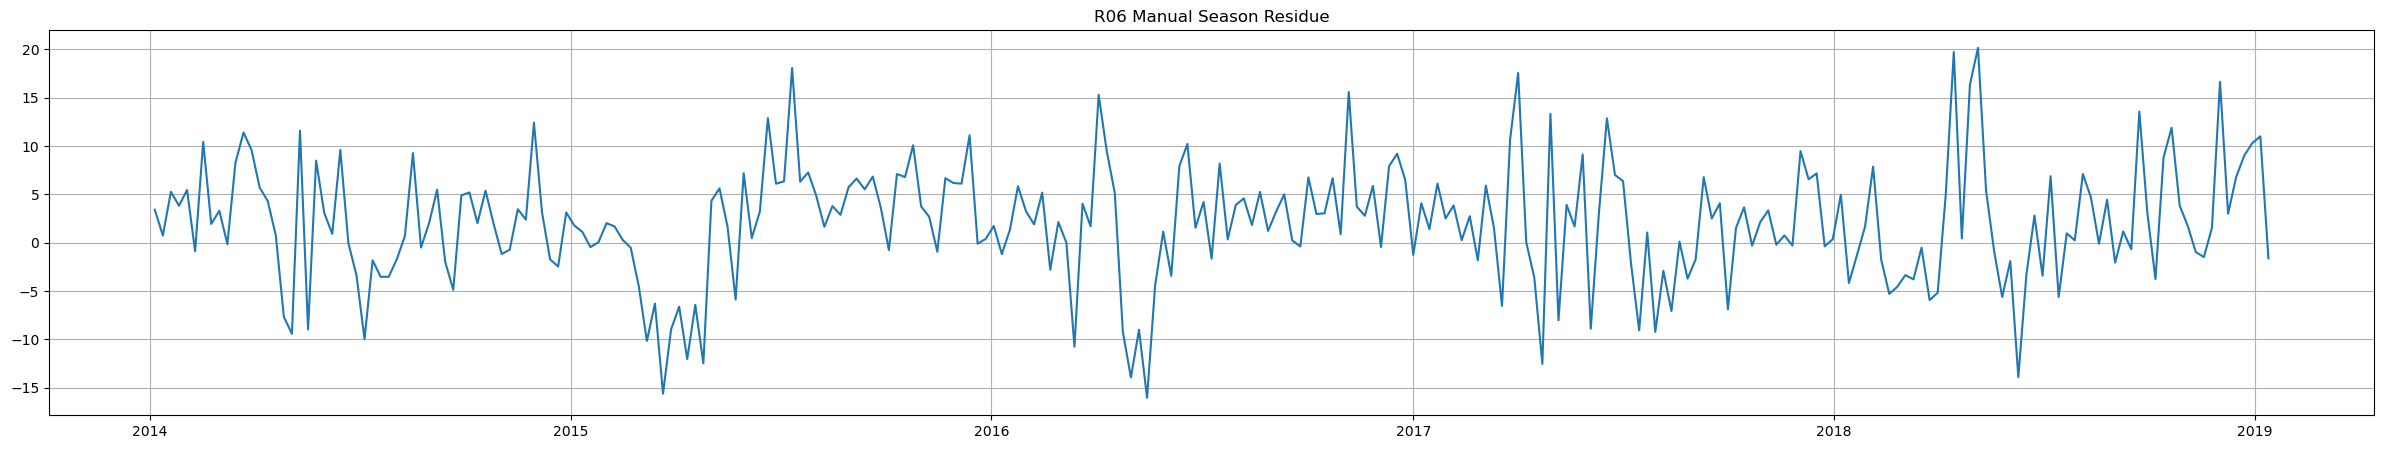

In [43]:
plt.figure(figsize=(30,5))
plt.plot(residue)
plt.grid()
plt.savefig("R06-residue-manual.png")
plt.title(med_name + " Manual Season Residue")
plt.savefig(med_name + "-residue-model-manual.png")

#### Size of the residue

In [44]:
MAEm = np.abs(residue).mean()
RMSEm = np.sqrt( np.square(residue).mean() )
MAEm, RMSEm

(5.010216912083399, 6.5137814292322815)

#### Stationarity of the residue

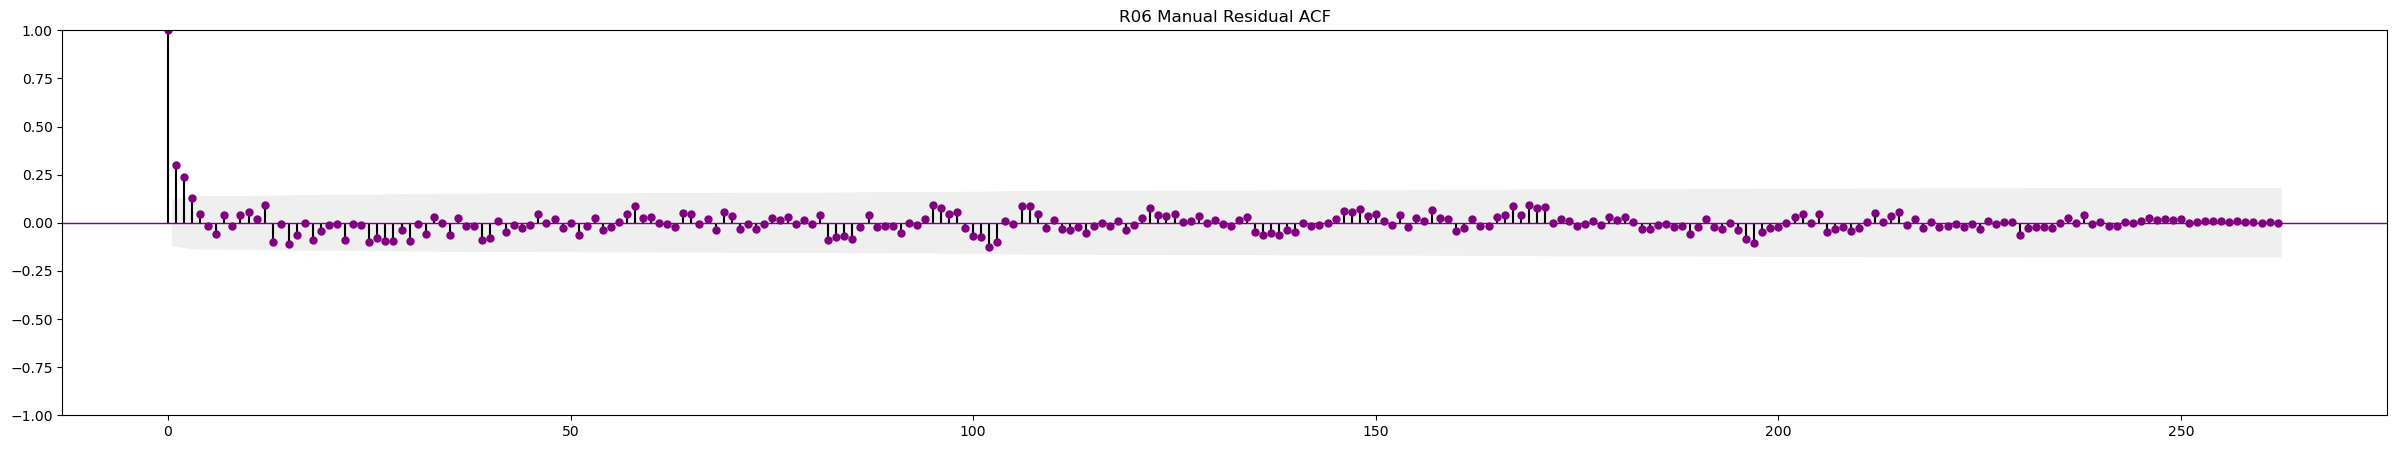

In [45]:
# _, ax = plt.subplots(figsize=(30,5))
# tsplots.plot_acf(residue,lags=262, ax=ax)
# plt.show()

f, ax = plt.subplots(figsize=(30,5))
plot_acf(residue, lags=262, ax=ax)
ax = plot_acf_colors(ax)
plt.title(med_name + " Manual Residual ACF")
plt.savefig(med_name + "-manual-residual-acf.png")

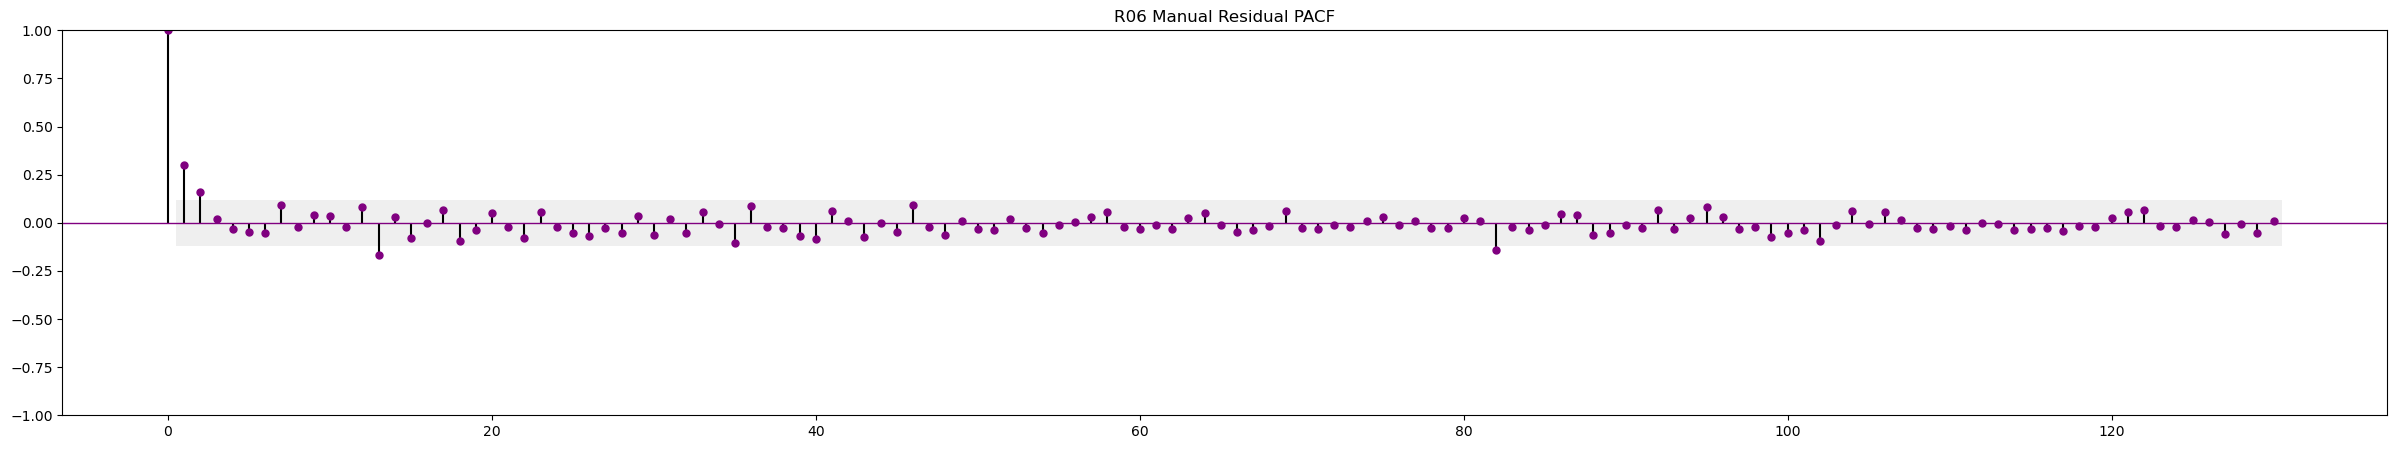

In [46]:
f, ax = plt.subplots(figsize=(30, 5))
plot_pacf(residue, lags=130, ax=ax)
ax = plot_acf_colors(ax)
plt.title(med_name + " Manual Residual PACF")
plt.savefig(med_name + "-manual-residual-pacf.png")

In [47]:
adf_test = adfuller(residue)
print('ADF Statistic: %f' % adf_test[0])
print('p-value: %f' % adf_test[1])
adf_test

ADF Statistic: -8.068649
p-value: 0.000000


(-8.0686492622153,
 1.5711688481398923e-12,
 1,
 261,
 {'1%': -3.4556556713934934,
  '5%': -2.872678352489859,
  '10%': -2.57270548832225},
 1578.8724866792818)

#### Forecast

In [48]:
f = len(y_r06_future)
f_periods = int(1 + f/period)
yhat_trend = pd.Series(index=y_r06_future.index, data=trend[-1])

/tmp/ipykernel_1091798/712906559.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  yhat_trend = pd.Series(index=y_r06_future.index, data=trend[-1])


In [49]:
yhat_seasonal = pd.Series(index=y_r06_future.index)
for i in range(len(yhat_seasonal)):
    yhat_seasonal[i] = seasonal[-(f_periods*len(mean_seasonals)-i)]

/tmp/ipykernel_1091798/2875649418.py:3: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  yhat_seasonal[i] = seasonal[-(f_periods*len(mean_seasonals)-i)]
/tmp/ipykernel_1091798/2875649418.py:3: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  yhat_seasonal[i] = seasonal[-(f_periods*len(mean_seasonals)-i)]


In [50]:
yhat = 2*yhat_trend*yhat_seasonal

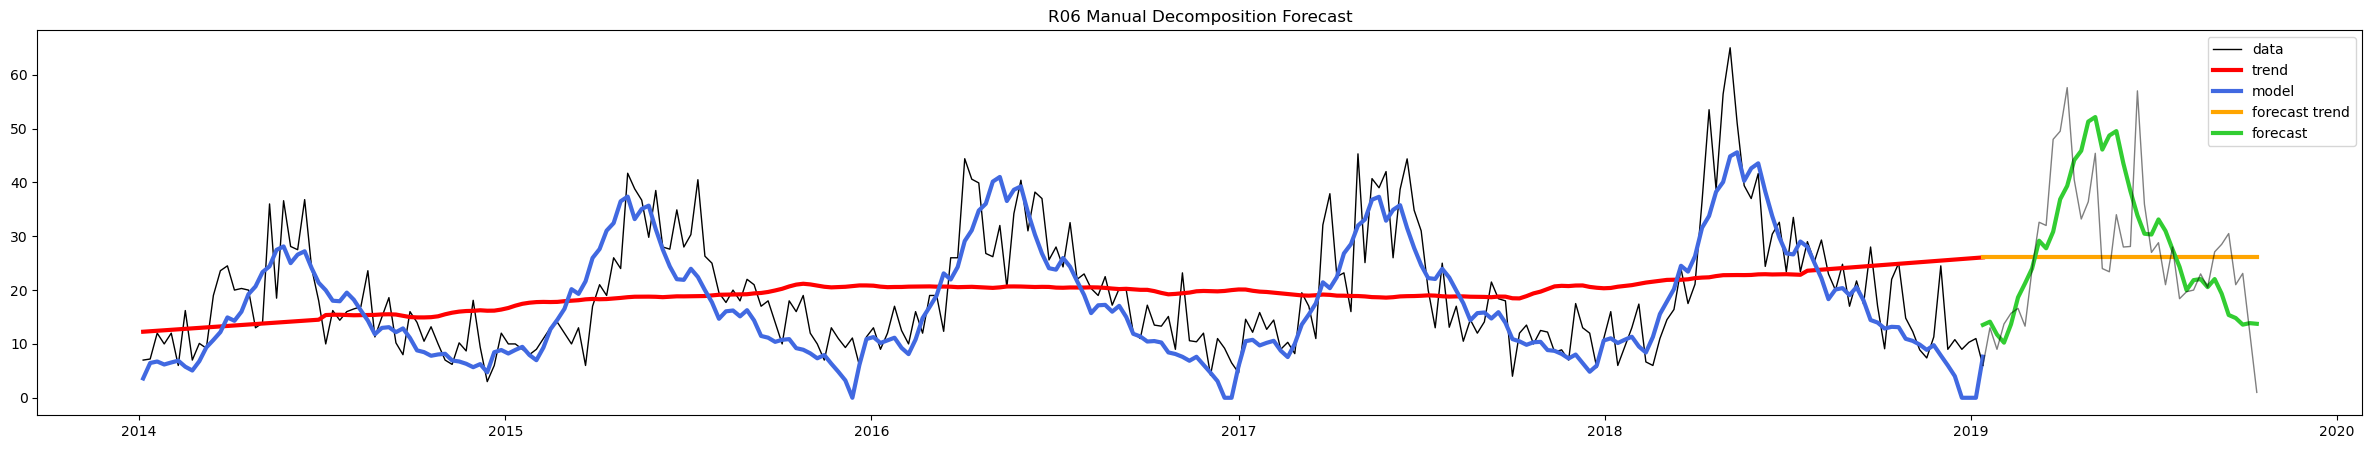

In [51]:
plt.figure(figsize=(30,5))
plt.plot(y_r06_hist,'k',label='data',linewidth=1)
plt.plot(trend,label='trend',color='red',linewidth=3)
plt.plot(season_and_trend,label='model',color='royalblue',linewidth=3)
plt.plot(yhat_trend,label='forecast trend',color='orange',linewidth=3)
plt.plot(yhat,label='forecast',color='limegreen',linewidth=3)
plt.plot(y_r06_future,'k',alpha=0.5,linewidth=1)
plt.legend();
plt.title(med_name + " Manual Decomposition Forecast")
plt.savefig(med_name + "-manual-decomp-forecast.png")

#### Prediction error

In [52]:
pred_error = y_r06_future - yhat

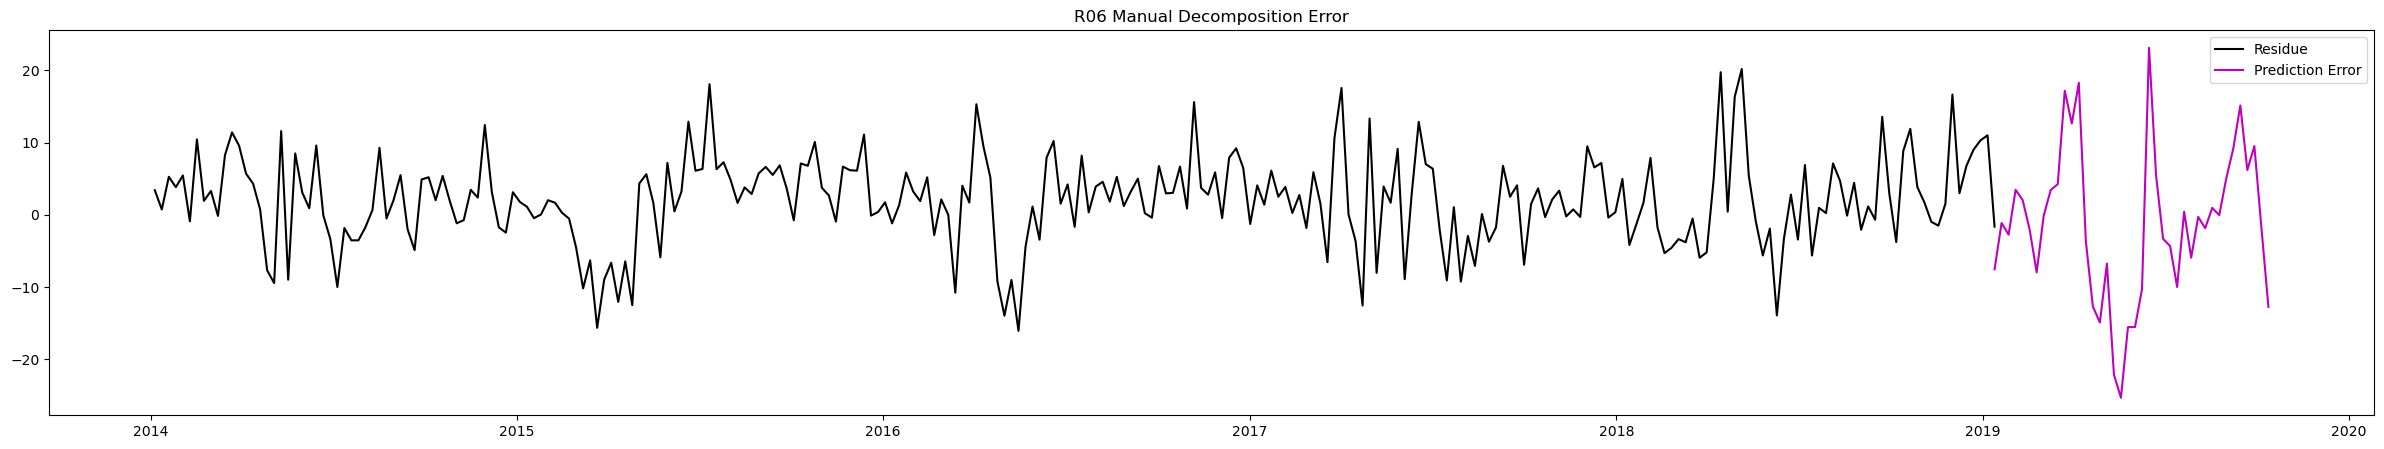

In [53]:
plt.figure(figsize=(30,5))
plt.plot(residue,'k',label='Residue')
plt.plot(pred_error,'m',label='Prediction Error')
plt.legend();
plt.title(med_name + " Manual Decomposition Error")
plt.savefig(med_name + "-manual-decomp-error.png")

In [54]:
MAEp = np.abs(pred_error).mean()
RMSEp = np.sqrt( np.square(pred_error).mean() )
MAEp, RMSEp

(8.116364753990501, 10.593812462238713)

### Problem 9: Score the Model

What is the accuracy of your model?

### Problem 10: Model Comparisons

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

### Problem 11: Improving the Model

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

### ARMA

In [55]:
r06_residual = r06_recon_df[['residual']]
r06_residual

,residual
datum,
2014-01-05,4.497688
2014-01-12,2.693591
2014-01-19,9.218661
2014-01-26,4.478880
2014-02-02,7.280178
...,...
2019-09-15,8.998833
2019-09-22,-1.068108
2019-09-29,4.882099


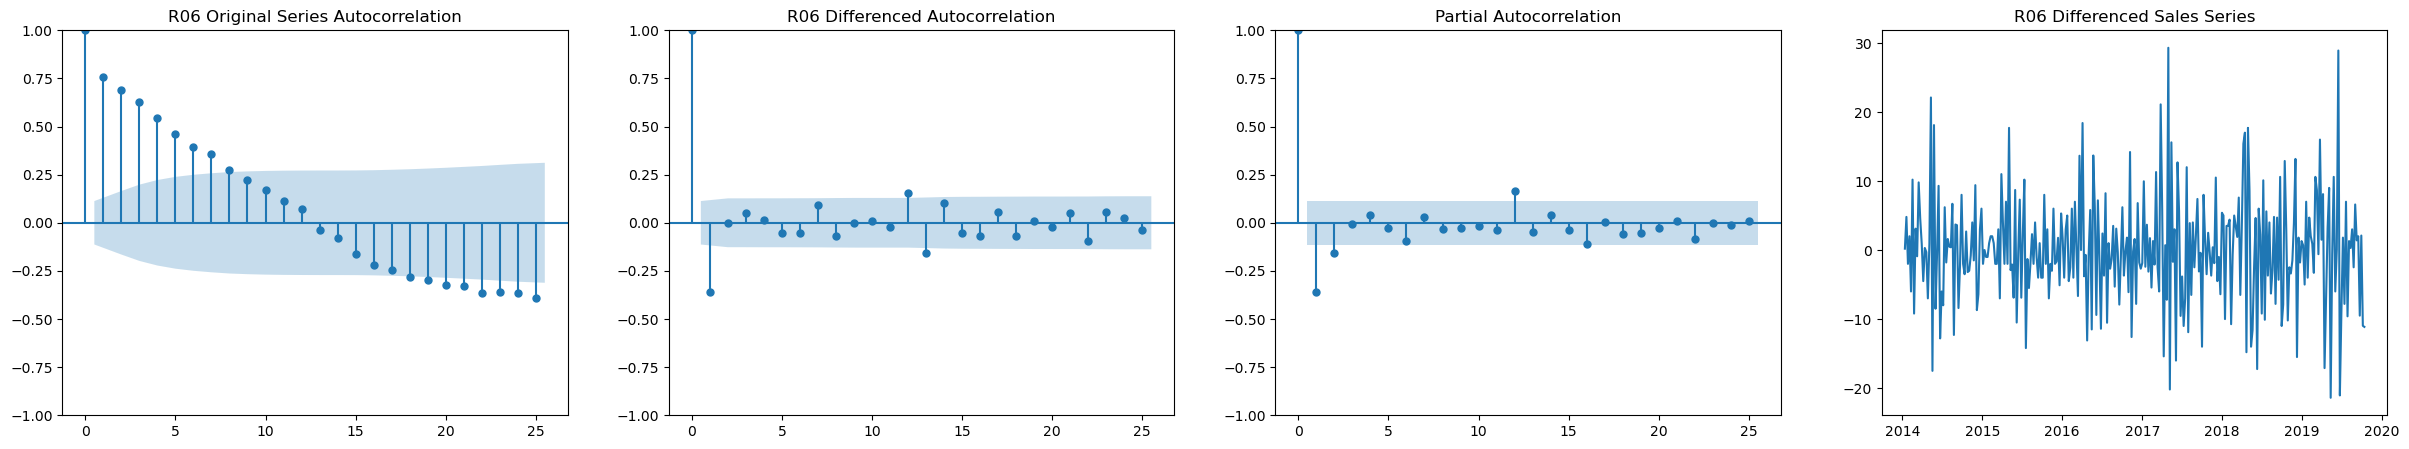

In [56]:
fig, ax = plt.subplots(1, 4, figsize = (30, 5))
plot_acf(df_r06_weekly['values'], ax = ax[0]);
ax[0].set_title(med_name + ' Original Series Autocorrelation')
plot_acf(df_r06_weekly['values'].diff().dropna(), ax = ax[1]);
ax[1].set_title(med_name + ' Differenced Autocorrelation')
plot_pacf(df_r06_weekly['values'].diff().dropna(), ax = ax[2], method = 'ywm');
ax[3].plot(df_r06_weekly['values'].diff().dropna())
ax[3].set_title(med_name + ' Differenced Sales Series');
plt.savefig(med_name + "-differenced-series.png")

In [57]:
X_train = y_r06_hist
X_test = y_r06_future

In [58]:
arma = ARIMA(X_train.diff(), order = (1, 0, 1), freq = 'W').fit()
preds = arma.forecast(len(X_test))
arma_mse_test = mean_squared_error(preds, X_test)

print(preds[:5])
print(arma_mse_test)

2019-01-20    2.186608
2019-01-27   -0.213415
2019-02-03    0.021997
2019-02-10   -0.001094
2019-02-17    0.001171
Freq: W-SUN, Name: predicted_mean, dtype: float64
871.6462378770059


/home/cratercruncher/miniconda3/envs/aiml_sandbox_1/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/cratercruncher/miniconda3/envs/aiml_sandbox_1/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/cratercruncher/miniconda3/envs/aiml_sandbox_1/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/cratercruncher/miniconda3/envs/aiml_sandbox_1/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be remo

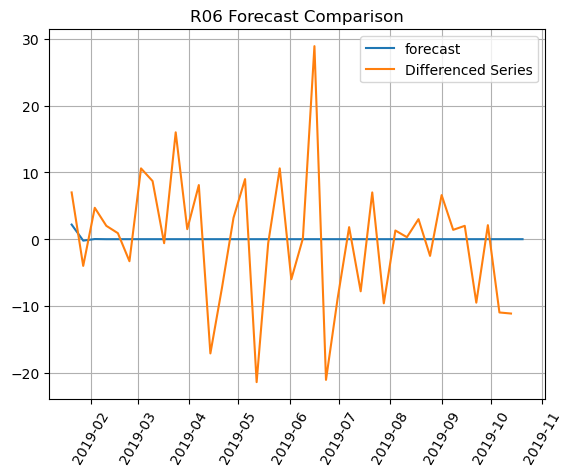

In [59]:
plt.plot(preds, label = 'forecast')
plt.plot(X_test.diff(), label = 'Differenced Series')
plt.legend();
plt.xticks(rotation = 60)
plt.grid();
plt.title(med_name + " Forecast Comparison")
plt.savefig(med_name + "-arma-forecast.png")

#### SARIMAX

In [60]:
sarima = SARIMAX(df_r06_weekly,  order=(1, 0, 1), seasonal_order=(1, 1, 0, 12)).fit(disp=0)
sarima.summary()

/home/cratercruncher/miniconda3/envs/aiml_sandbox_1/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
/home/cratercruncher/miniconda3/envs/aiml_sandbox_1/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                              values   No. Observations:                  302
Model:             SARIMAX(1, 0, 1)x(1, 1, [], 12)   Log Likelihood               -1029.437
Date:                             Sat, 16 Mar 2024   AIC                           2066.875
Time:                                     18:08:20   BIC                           2081.554
Sample:                                 01-05-2014   HQIC                          2072.756
                                      - 10-13-2019                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9298      0.026     36.264      0.000       0.880       0.980
ma.L1         -0.3456      0.065     -5.303      0.000      -0.473      -0.218
ar.S.L12      -0.4621      0.051     -9.141      0.000      -0.561      -0.363
sigma2        69.9874      5.128     13.648      0.000      59.936      80.038
===================================================================================
Ljung-Box (L1) (Q):                   0.29   Jarque-Bera (JB):                14.73
Prob(Q):                              0.59   Prob(JB):                         0.00
Heteroskedasticity (H):               2.10   Skew:                             0.41
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.73
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [61]:
# Calculate the mean absolute error from residuals
mae = np.mean(np.abs(sarima.resid))

# Print mean absolute error
print('MAE: %.3f' % mae)

MAE: 6.638


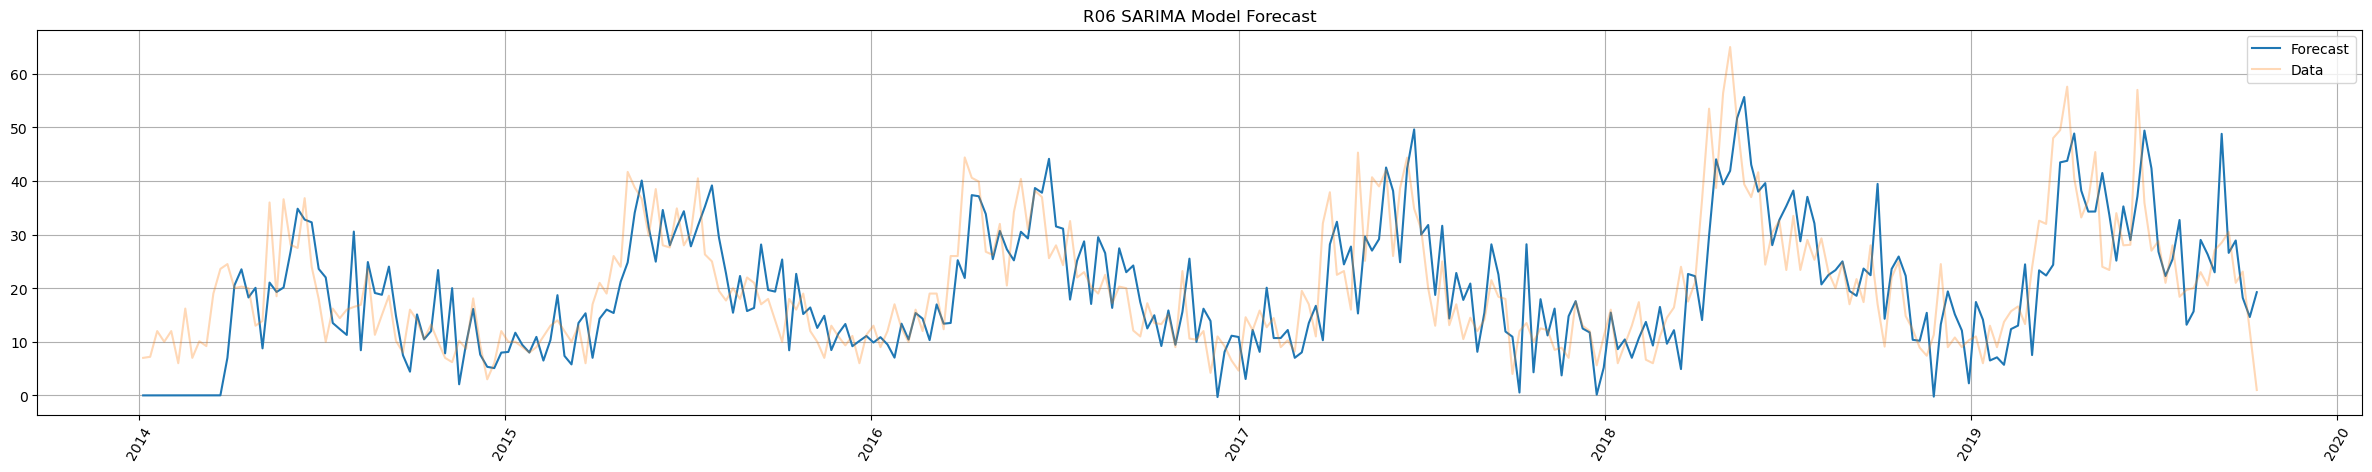

In [62]:
plt.figure(figsize=(30,5))
plt.plot(df_r06_weekly.index, sarima.predict(), label = 'Forecast' )
plt.plot(df_r06_weekly.index, df_r06_weekly, alpha = 0.3, label = 'Data')
plt.xticks(rotation = 60)
plt.title(med_name + " SARIMA Model Forecast")
plt.savefig(med_name + "-sarima-forecast.png")
plt.grid();
plt.legend();

In [63]:
sarimax_mse_test = mean_squared_error(sarima.predict(), df_r06_weekly)

print(sarimax_mse_test)

74.79627309930196


/home/cratercruncher/miniconda3/envs/aiml_sandbox_1/lib/python3.11/site-packages/sklearn/utils/validation.py:605: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype):
/home/cratercruncher/miniconda3/envs/aiml_sandbox_1/lib/python3.11/site-packages/sklearn/utils/validation.py:614: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(pd_dtype) or not is_extension_array_dtype(pd_dtype):
/home/cratercruncher/miniconda3/envs/aiml_sandbox_1/lib/python3.11/site-packages/sklearn/utils/validation.py:767: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if not hasattr(array, "sparse") and array.dtypes.apply(is_sparse).any():
/home/cratercruncher/miniconda3/envs/aiml_sandbox_1/lib/python3.11/site-packages/sklearn/utils/v

### RNN

##### Scale the data

In [64]:
X = df_r06_weekly.drop(columns=df_r06_weekly.columns[0])
Y = df_r06_weekly[['values']]

In [65]:
X

""
datum
2014-01-05
2014-01-12
2014-01-19
2014-01-26
2014-02-02
...
2019-09-15
2019-09-22
2019-09-29


In [66]:
Y

,values
datum,
2014-01-05,7.00
2014-01-12,7.20
2014-01-19,12.00
2014-01-26,10.00
2014-02-02,12.00
...,...
2019-09-15,30.50
2019-09-22,21.00
2019-09-29,23.10


In [67]:
raw_data = Y['values'].values
data = raw_data

In [68]:
scaler = MinMaxScaler(feature_range=(0, 1))
raw_data = scaler.fit_transform(raw_data.reshape(-1, 1))

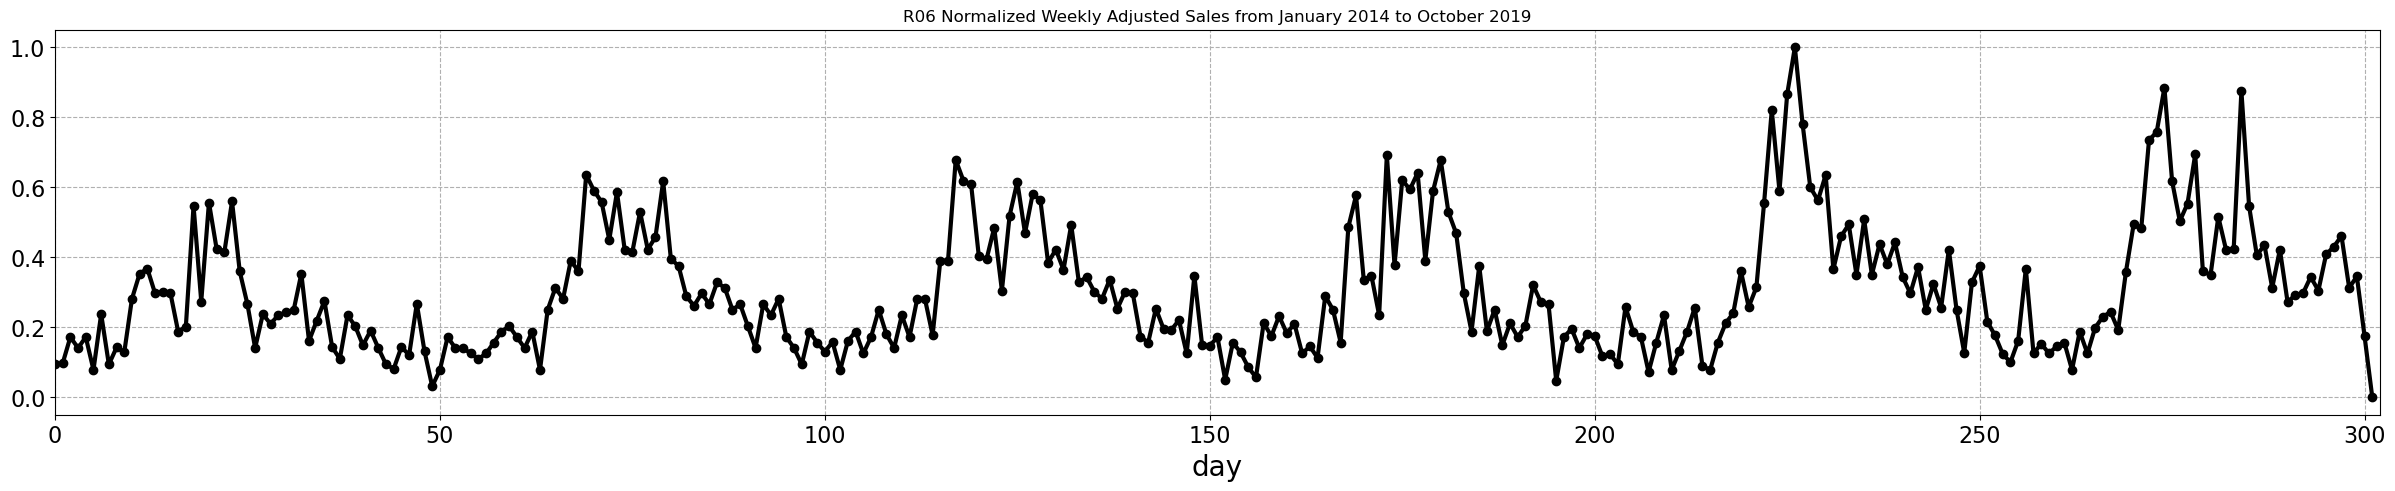

In [69]:
plt.figure(figsize=(30,5))
plt.plot(raw_data[:303],'ko-',linewidth=3)
plt.grid(linestyle='--')
plt.xlim(0,302)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('day',fontsize=20)
plt.title(med_name + " Normalized Weekly Adjusted Sales from January 2014 to October 2019")
plt.savefig(med_name + "-normalized.png")

##### Train/test data

In [70]:
dotrain = True
dotest = True
doanim = False

epochs = 813
batch_size = 32

dense_numunits = 16
conv1d_numunits = 32
simplernn_numunits = 16
lstm_numunits = 16

history_length = 6
forecast_length = 24

np.random.seed(237)
tensorflow.random.set_seed(237)

In [71]:
def build_window(data, h, f):
    
    dataX, dataY = [], []
    
    for i in range(len(data)-h-f):
        dataX.append(data[i:(i+h)])
        dataY.append(data[(i+h):(i+h+f)])
        
    dataX = np.array(dataX)
    dataX = np.reshape(dataX, (dataX.shape[0], 1, dataX.shape[1]))
    
    dataY = np.array(dataY)
    
    return dataX, dataY

In [72]:
dataX, dataY = build_window(data, history_length, forecast_length)
data.shape, dataX.shape, dataY.shape

((302,), (272, 1, 6), (272, 24))

In [73]:
num_train_samples = int(0.8 * len(raw_data))
trainX, trainY = dataX[:num_train_samples,:,:], dataY[:num_train_samples,:]
valX,  valY    = dataX[num_train_samples:,:,:], dataY[num_train_samples:,:]
trainX.shape, trainY.shape, valX.shape,  valY.shape

((241, 1, 6), (241, 24), (31, 1, 6), (31, 24))

##### DENSE

In [74]:
# model_dense = Sequential()
# model_dense.add(Flatten())
# model_dense.add(Dense(16, activation="relu"))
# model_dense.add(Dense(24))

In [75]:
# model_dense.compile(loss="mse", metrics=["mae"], optimizer="adam")

# history_dense = model_dense.fit(trainX, trainY, 
#                                 epochs=500, 
#                                 batch_size=32,
#                                 validation_data = (valX, valY) )

In [76]:
model_dense = Sequential()
model_dense.add(Flatten())
model_dense.add(Dense(dense_numunits, activation="relu"))
model_dense.add(Dense(forecast_length))

model_dense.compile(loss="mse", metrics=["mae", 'acc'], optimizer="adam")

history_dense = model_dense.fit(trainX, trainY, 
                              epochs=epochs, 
                              batch_size=batch_size,
                              validation_data = (valX, valY),
                              verbose=1)

model_dense.summary()

Epoch 1/813


2024-03-16 18:08:21.487874: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


8/8 [==============================] - 1s 28ms/step - loss: 569.0131 - mae: 18.8372 - acc: 0.0290 - val_loss: 879.9035 - val_mae: 24.7180 - val_acc: 0.0323
Epoch 2/813
8/8 [==============================] - 0s 8ms/step - loss: 532.7160 - mae: 18.1101 - acc: 0.0290 - val_loss: 837.6682 - val_mae: 24.0159 - val_acc: 0.0323
Epoch 3/813
8/8 [==============================] - 0s 8ms/step - loss: 499.5954 - mae: 17.4501 - acc: 0.0415 - val_loss: 800.1938 - val_mae: 23.3663 - val_acc: 0.0645
Epoch 4/813
8/8 [==============================] - 0s 8ms/step - loss: 470.3576 - mae: 16.8653 - acc: 0.0498 - val_loss: 767.0435 - val_mae: 22.7722 - val_acc: 0.0645
Epoch 5/813
8/8 [==============================] - 0s 9ms/step - loss: 444.7629 - mae: 16.3373 - acc: 0.0830 - val_loss: 736.8329 - val_mae: 22.2130 - val_acc: 0.0323
Epoch 6/813
8/8 [==============================] - 0s 9ms/step - loss: 422.1938 - mae: 15.8757 - acc: 0.1120 - val_loss: 709.3324 - val_mae: 21.6904 - val_acc: 0.0323
Epoch 7/8

##### Simple RNN

In [77]:
# model_simprnn = Sequential()
# model_simprnn.add(SimpleRNN(16, input_shape=(1,6)))             
# model_simprnn.add(Dense(24))
# model_simprnn.compile(loss="mse", metrics=["mae"], optimizer="adam")

# history_simprnn = model_simprnn.fit(trainX, trainY, 
#                                   epochs=500, 
#                                   batch_size=32, 
#                                   validation_data = (testX, testY) )

In [78]:
model_simprnn = Sequential()
model_simprnn.add(SimpleRNN(simplernn_numunits, input_shape=(1,history_length)))             
model_simprnn.add(Dense(forecast_length))

model_simprnn.compile(loss="mse", metrics=["mae", "acc"], optimizer="adam")

history_simprnn = model_simprnn.fit(trainX, trainY, 
                                  epochs=epochs, 
                                  batch_size=batch_size, 
                                  validation_data = (valX, valY),
                                  verbose=1)

model_simprnn.summary()

Epoch 1/813
8/8 [==============================] - 1s 49ms/step - loss: 505.3862 - mae: 19.6084 - acc: 0.0249 - val_loss: 893.7285 - val_mae: 26.5504 - val_acc: 0.0000e+00
Epoch 2/813
8/8 [==============================] - 0s 9ms/step - loss: 500.0741 - mae: 19.4722 - acc: 0.0290 - val_loss: 886.8766 - val_mae: 26.4213 - val_acc: 0.0000e+00
Epoch 3/813
8/8 [==============================] - 0s 9ms/step - loss: 494.7978 - mae: 19.3380 - acc: 0.0290 - val_loss: 880.1104 - val_mae: 26.2928 - val_acc: 0.0000e+00
Epoch 4/813
8/8 [==============================] - 0s 9ms/step - loss: 489.5039 - mae: 19.2026 - acc: 0.0290 - val_loss: 873.5663 - val_mae: 26.1676 - val_acc: 0.0000e+00
Epoch 5/813
8/8 [==============================] - 0s 12ms/step - loss: 484.4035 - mae: 19.0660 - acc: 0.0332 - val_loss: 867.1948 - val_mae: 26.0447 - val_acc: 0.0000e+00
Epoch 6/813
8/8 [==============================] - 0s 14ms/step - loss: 479.4414 - mae: 18.9343 - acc: 0.0332 - val_loss: 860.8338 - val_mae: 2

##### LTSM

In [79]:
# model_lstm = Sequential()
# model_lstm.add(LSTM(16, input_shape=(1, 6)))
# model_lstm.add(Dense(24))
# model.compile(loss='mse', metrics=["mae"])

# history = model.fit(trainX, trainY, 
#                  epochs=500, 
#                  batch_size=32, 
#                  validation_data = (valX, valY) )

In [80]:
model_lstm = Sequential()
model_lstm.add(LSTM(lstm_numunits, input_shape=(1, history_length)))
model_lstm.add(Dense(forecast_length))

model_lstm.compile(loss='mse', metrics=["mae"], optimizer='adam')

history_lstm = model_lstm.fit(trainX, trainY, 
                         epochs=epochs, 
                         batch_size=batch_size, 
                         validation_data = (valX, valY),
                         verbose=1)

model_lstm.summary()

Epoch 1/813


2024-03-16 18:10:50.637522: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-16 18:10:50.638673: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-16 18:10:50.639628: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

8/8 [==============================] - 2s 56ms/step - loss: 502.7140 - mae: 19.5661 - val_loss: 894.9199 - val_mae: 26.5624
Epoch 2/813
1/8 [==>...........................] - ETA: 0s - loss: 555.7058 - mae: 20.8523

2024-03-16 18:10:52.271568: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2024-03-16 18:10:52.272723: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2024-03-16 18:10:52.273594: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

8/8 [==============================] - 0s 13ms/step - loss: 500.2316 - mae: 19.4997 - val_loss: 891.3744 - val_mae: 26.4964
Epoch 3/813
8/8 [==============================] - 0s 7ms/step - loss: 496.9328 - mae: 19.4129 - val_loss: 886.5599 - val_mae: 26.4061
Epoch 4/813
8/8 [==============================] - 0s 9ms/step - loss: 492.8176 - mae: 19.3065 - val_loss: 880.4427 - val_mae: 26.2899
Epoch 5/813
8/8 [==============================] - 0s 7ms/step - loss: 488.1245 - mae: 19.1810 - val_loss: 873.5690 - val_mae: 26.1572
Epoch 6/813
8/8 [==============================] - 0s 8ms/step - loss: 482.6281 - mae: 19.0347 - val_loss: 865.2977 - val_mae: 25.9966
Epoch 7/813
8/8 [==============================] - 0s 9ms/step - loss: 476.3177 - mae: 18.8667 - val_loss: 855.7162 - val_mae: 25.8112
Epoch 8/813
8/8 [==============================] - 0s 8ms/step - loss: 469.4651 - mae: 18.6815 - val_loss: 845.7289 - val_mae: 25.6172
Epoch 9/813
8/8 [==============================] - 0s 6ms/step - l

In [81]:
# n_steps=5
# n_features = 1

# model_lstm_2 = Sequential()
# model_lstm_2.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(1, history_length)))
# model_lstm_2.add(LSTM(100, activation='relu'))
# model_lstm_2.add(Dense(1))
# model_lstm_2.compile(optimizer='adam', loss='mse')
# history_lstm_2 = model_lstm_2.fit(trainX, trainY, 
#                          epochs=epochs, 
#                          batch_size=batch_size, 
#                          validation_data = (valX, valY),
#                          verbose=0)
# model_lstm_2.summary()

In [82]:
# n_steps=5
# n_features = 1

model_lstm_2 = Sequential()
model_lstm_2.add(LSTM(lstm_numunits, activation='relu', return_sequences=True, input_shape=(1, history_length)))
model_lstm_2.add(LSTM(lstm_numunits, activation='relu'))
model_lstm_2.add(Dense(forecast_length))
model_lstm_2.compile(loss='mse', metrics=["mae"], optimizer='adam')
history_lstm_2 = model_lstm_2.fit(trainX, trainY, 
                         epochs=epochs, 
                         batch_size=batch_size, 
                         validation_data = (valX, valY),
                         verbose=1)
model_lstm_2.summary()

Epoch 1/813
8/8 [==============================] - 2s 41ms/step - loss: 501.1909 - mae: 19.5287 - val_loss: 893.3159 - val_mae: 26.5203
Epoch 2/813
8/8 [==============================] - 0s 11ms/step - loss: 497.9015 - mae: 19.4358 - val_loss: 889.0098 - val_mae: 26.4223
Epoch 3/813
8/8 [==============================] - 0s 8ms/step - loss: 494.0023 - mae: 19.3223 - val_loss: 883.8982 - val_mae: 26.3060
Epoch 4/813
8/8 [==============================] - 0s 12ms/step - loss: 489.4180 - mae: 19.1855 - val_loss: 877.5412 - val_mae: 26.1620
Epoch 5/813
8/8 [==============================] - 0s 9ms/step - loss: 483.8711 - mae: 19.0114 - val_loss: 869.1586 - val_mae: 25.9727
Epoch 6/813
8/8 [==============================] - 0s 12ms/step - loss: 476.6248 - mae: 18.7805 - val_loss: 857.2225 - val_mae: 25.7030
Epoch 7/813
8/8 [==============================] - 0s 7ms/step - loss: 466.1906 - mae: 18.4452 - val_loss: 838.0753 - val_mae: 25.2662
Epoch 8/813
8/8 [==============================] - 

##### PLOT

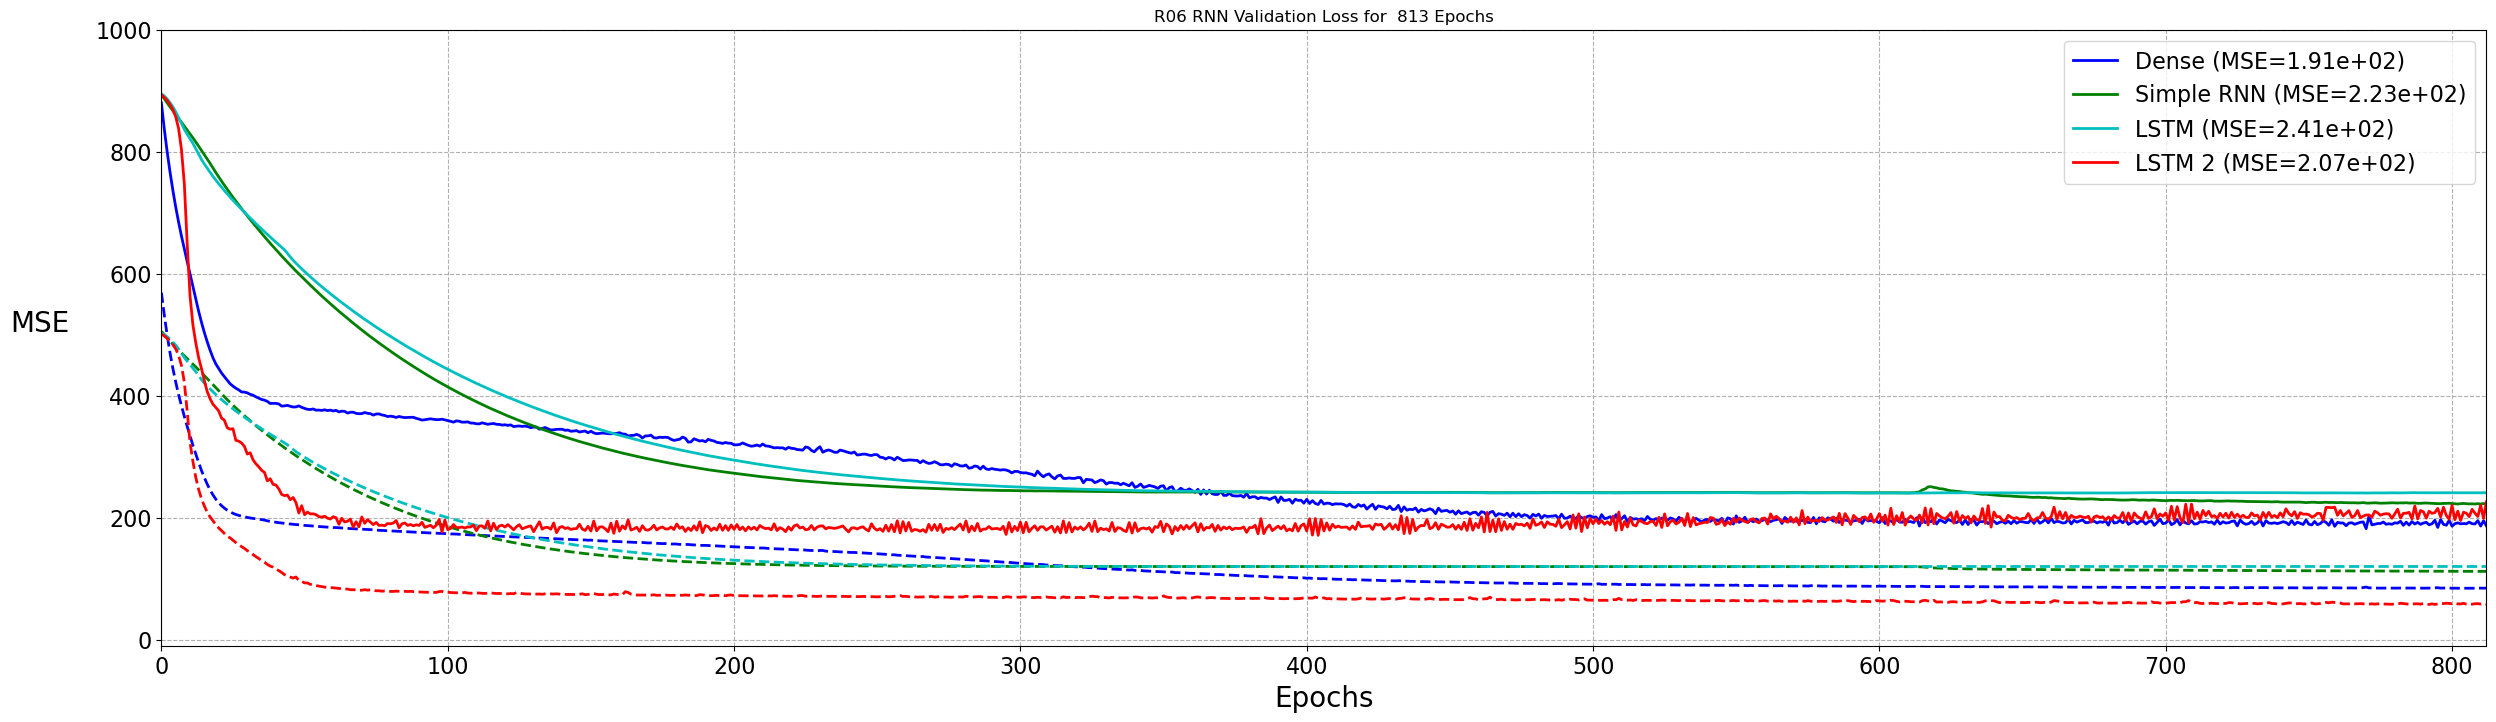

In [83]:
e = range(epochs)

mse_dense = np.mean(history_dense.history['val_loss'][-5:-1])
mse_simprnn = np.mean(history_simprnn.history['val_loss'][-5:-1])
mse_lstm = np.mean(history_lstm.history['val_loss'][-5:-1])
mse_lstm_2 = np.mean(history_lstm_2.history['val_loss'][-5:-1])


plt.figure(figsize=(30,8))
plt.plot(e,history_dense.history['loss'], 'b--', linewidth=2)
plt.plot(e,history_dense.history['val_loss'], 'b-', linewidth=2,label='Dense (MSE={:.2e})'.format(mse_dense))
plt.plot(e,history_simprnn.history['loss'], 'g--', linewidth=2)
plt.plot(e,history_simprnn.history['val_loss'], 'g-', linewidth=2,label='Simple RNN (MSE={:.2e})'.format(mse_simprnn))
plt.plot(e,history_lstm.history['loss'], 'c--', linewidth=2)
plt.plot(e,history_lstm.history['val_loss'], 'c-', linewidth=2, label='LSTM (MSE={:.2e})'.format(mse_lstm))
plt.plot(e,history_lstm_2.history['loss'], 'r--', linewidth=2)
plt.plot(e,history_lstm_2.history['val_loss'], 'r-', linewidth=2, label='LSTM 2 (MSE={:.2e})'.format(mse_lstm_2))
plt.xlim(0,epochs-1)
plt.ylim(-10,1000)
plt.legend(fontsize=16)
plt.grid(linestyle='--')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel('Epochs',fontsize=20)
plt.ylabel('MSE',fontsize=20,rotation=0, labelpad=40)
plt.title(med_name + " RNN Validation Loss for " + f" {epochs} Epochs")
plt.savefig(med_name + '-' + f"{epochs}-epochs-{batch_size}-batch-rnn-validation-loss.png")

##### Questions